In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy.optimize
import scipy.stats
import csv
import json
import ast
import itertools
from scipy.io import loadmat
from datetime import datetime
sns.set_theme()

In this file:
- coarse grained analysis (on 1 hour time scale)
- importing pattern, outcome, hourly stats, daily stats, outcome/phase split dfs
- analysis of common patterns across all subjects
- analysis of patterns in multiple subjects split by phase

# Importing files 

In [2]:
# importing pattern dfs
patt_data = glob.glob('coarse/patt_dfs_updated/*****_coarse.json')

patt_dfs = []
for file in patt_data:
    subj_id = file[24:29]
    df = pd.read_json(file, orient='records')
    df['ID'] = subj_id
    patt_dfs.append(df)

In [3]:
# importing hourly stats dfs
stats_data = glob.glob('stats_dfs/hour_updated/*****.csv')

stats_dfs = []
for file in stats_data:
    df = pd.read_csv(file, low_memory = False)
    stats_dfs.append(df)

In [5]:
# importing outcome dfs
outcome_data = glob.glob('coarse/outcome_dfs_updated/*****_coarse.csv')

outcome_dfs = []
for file in outcome_data:
    subj_id = file[27:32]
    df = pd.read_csv(file, low_memory = False)
    df['ID'] = subj_id
    outcome_dfs.append(df)

In [257]:
# importing outcome dfs split by time blocks
time_outcome_data = glob.glob('coarse/time_outcome_updated/*****_coarse.csv')

time_div_dfs = []
for file in time_outcome_data:
    subj_id = file[28:33]
    df = pd.read_csv(file, low_memory = False)
    df['ID'] = subj_id
    time_div_dfs.append(df)

In [43]:
# importing outcome dfs split by phase
phase_outcome_data = glob.glob('coarse/phase_outcome_updated/*****_coarse.csv')

phase_div_dfs = []
for file in phase_outcome_data:
    subj_id = file[29:34]
    df = pd.read_csv(file, low_memory = False)
    df['ID'] = subj_id
    df.rename(columns={'phase1_runs' :'p1_runs', 'phase2_runs': 'p2_runs', 'phase3_runs':'p3_runs', 'phase4_runs':'p4_runs'}, inplace=True)
    phase_div_dfs.append(df)

In [8]:
# importing day stats dfs
day_stats_data = glob.glob('stats_dfs/day_updated/*****.csv')

day_stats_dfs = []
for file in day_stats_data:
    df = pd.read_csv(file, low_memory = False)
    day_stats_dfs.append(df)

# Total outcomes analysis

In [9]:
# adding all patterns from all subjects to one df
all_patt = outcome_dfs[0].copy()
for i in range(1, len(outcome_dfs)):
    all_patt = pd.concat([all_patt, outcome_dfs[i]])
all_patt = all_patt.reset_index(drop = True)

In [11]:
def all_patt_stats(all_patt):
    ''' creates a stats df from all patterns across all subjects by indexing by each unique pattern'''
    patt_cols = ['patt', 'length', 'unique_blocks', 'incl_low', 'incl_high', 'incl_food', 'seen_subj_ids',
                 'perc_subj_seen', 'num_subj', 'avg_repeats', 'min_repeats', 'max_repeats', 'tot_repeats',
                 'tot_outcomes', 'tot_lows', 'perc_lows', 'tot_highs', 'perc_highs', 'tot_vhighs', 'perc_vhighs',
                 'cgm_mean', 'lbgi_mean', 'lbgi_risk_mean', 'hbgi_mean', 'hbgi_risk_mean', 
                 'tir_mean', 'tbr_mean', 'tar_mean', 'tvar_mean', 'abs_min_val',
                 'abs_max_val', 'avg_min_val', 'avg_max_val', 'avg_min_time',
                 'avg_max_time', 'end_cgm']

    all_patt_data = []

    # all patterns must be longer than or equal 3 hours 
    patt_arr = all_patt[all_patt['length'] >= 3]['pattern'].unique()

    for patt in patt_arr:
        singlepatt = all_patt[all_patt['pattern'] == str(patt)].copy()
        # pattern info 
        patt = singlepatt.iloc[0]['pattern']
        length = singlepatt.iloc[0]['length']
        unique_blocks = singlepatt.iloc[0]['unique_blocks']
        incl_low = singlepatt.iloc[0]['incl_low']
        incl_high = singlepatt.iloc[0]['incl_high']
        incl_food = singlepatt.iloc[0]['incl_food']

        # subjs, repeat statistics
        seen_subj_ids = singlepatt['ID'].values
        num_subj = len(seen_subj_ids)
        perc_subj_seen = num_subj / len(all_patt['ID'].unique())
        avg_repeats = singlepatt['repeats'].mean()
        min_repeats = singlepatt['repeats'].min()
        max_repeats = singlepatt['repeats'].max()
        tot_repeats = singlepatt['repeats'].sum()

        # outcome statistics
        tot_outcomes = singlepatt['unique_outcomes'].sum()
        tot_lows = singlepatt['low_count'].sum()
        perc_lows = tot_lows / tot_outcomes
        tot_highs = singlepatt['high_count'].sum()
        perc_highs = tot_highs / tot_outcomes
        tot_vhighs = singlepatt['vhigh_count'].sum()
        perc_vhighs = tot_vhighs / tot_outcomes

        patt_stats = [patt, length, unique_blocks, incl_low, incl_high, incl_food, seen_subj_ids,
                     perc_subj_seen, num_subj, avg_repeats, min_repeats, max_repeats, tot_repeats,
                     tot_outcomes, tot_lows, perc_lows, tot_highs, perc_highs, tot_vhighs, perc_vhighs]
        
        # weighted avg outcomes - checking if exists, then adding to stats arr 
        weighted_stats = ['avg_cgm', 'avg_lbgi', 'avg_lbgi_risk', 'avg_hbgi', 'avg_hbgi_risk', 
                          'avg_tir', 'avg_tbr', 'avg_tar', 'avg_tvar', 'abs_min_val',
                          'abs_max_val', 'avg_min_val', 'avg_max_val', 'avg_min_time',
                          'avg_max_time', 'end_cgm']
        
        for stat in weighted_stats:
            slicedf = singlepatt[singlepatt[stat].notnull()]

            if len(slicedf) != 0: # if stat exists, weight outcome by # of repeats seen in that subject
                avg_stat = np.average(a=slicedf[stat], weights=slicedf['repeats'])

            else: # if stat does not exist, nan
                avg_stat = np.nan
            patt_stats.append(avg_stat)

        all_patt_data.append(patt_stats)

    patt_stats_df = pd.DataFrame(all_patt_data)
    patt_stats_df.columns = patt_cols
    patt_stats_df = patt_stats_df[patt_stats_df['num_subj'] > 1] # removes any patterns seen in only 1 subject
    
    return patt_stats_df

In [12]:
all_patt_stats_df = all_patt_stats(all_patt)

In [16]:
# adding num unique blocks col
num_blocks_list = []
for i in range(len(all_patt)):
    string = all_patt.iloc[i]['unique_blocks'].replace('"','').replace("'", '"').replace('  ', ',') # fix weirdness with import/exporting arrays
    num_blocks_list.append(len(json.loads(string))) # get number of unique blocks 

all_patt['num_unique_blocks'] = num_blocks_list # set col

# Total outcomes analysis, with phases

In [ ]:
# making phase div all pattern dataframe
all_patt_phases = phase_div_dfs[0].copy()
for df in phase_div_dfs:
    all_patt_phases = pd.concat([all_patt_phases, df])
all_patt_phases = all_patt_phases.reset_index(drop = True)

In [49]:
# adding unique block values 
num_blocks_phases_list = []
for i in range(len(all_patt_phases)):
    string = all_patt_phases.iloc[i]['unique_blocks'].replace('"','').replace("'", '"').replace('  ', ',')
    num_blocks_phases_list.append(len(json.loads(string))) 
all_patt_phases['num_unique_blocks'] = num_blocks_phases_list

In [252]:
def all_patt_stats_phases(all_patt):
    ''' sorts all patterns into phase divisions - phases are split using phase col instead of every phase in same row '''
    patt_cols = ['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'phase', 'incl_low', 'incl_high', 'incl_food', 'seen_subj_ids',
             'perc_subj_seen', 'num_subj', 'avg_repeats', 'min_repeats', 'max_repeats', 'tot_repeats',
             'tot_outcomes', 'tot_lows', 'perc_lows', 'tot_highs', 'perc_highs', 'tot_vhighs', 'perc_vhighs',
             'cgm_mean', 'lbgi_mean', 'lbgi_mean_risk', 'hbgi_mean', 'hbgi_mean_risk',
             'tir_mean', 'tbr_mean', 'tar_mean', 'tvar_mean', 'abs_min_val', 'abs_max_val', 'avg_min_val', 'avg_max_val', 
             'avg_min_time', 'avg_max_time', 'end_cgm']

    all_patt_data = []
    phases = [1, 2, 3, 4]

    # only getting patterns >= 3 hours long
    patt_arr = all_patt[all_patt['length'] >= 3]['pattern'].unique()

    # getting stats for each phase for each pattern 
    for patt in patt_arr:
        singlepatt = all_patt[all_patt['pattern'] == patt].copy() # getting stats row for all subjects/phases a pattern is seen in 

        # base pattern info 
        patt = singlepatt.iloc[0]['pattern']
        length = singlepatt.iloc[0]['length']
        unique_blocks = singlepatt.iloc[0]['unique_blocks']
        num_unique_blocks = singlepatt.iloc[0]['num_unique_blocks']
        incl_low = singlepatt.iloc[0]['incl_low']
        incl_high = singlepatt.iloc[0]['incl_high']
        incl_food = singlepatt.iloc[0]['incl_food']

        # subj information - which, how many, what percent. not split by phase
        seen_subj_ids = singlepatt['ID'].unique()
        num_subj = len(seen_subj_ids)
        perc_subj_seen = num_subj / 30
        
        for phase in phases: # getting stats for pattern in each phase
            abbv = 'p' + str(phase) + '_' # for clear column titles - adds 'p1_', 'p2_', 'p3_', or 'p4_'  

            # getting repeat vals
            repeats_list = []

            for i in range(len(singlepatt)): # for each occurrence, get start inds of runs 
                run_val = singlepatt.iloc[i][abbv + 'runs']
                
                if str(run_val) == 'nan': # if no runs, 0 repeats
                    repeats_list.append(0)

                else:
                    run_list = (json.loads(singlepatt.iloc[i][abbv + 'runs'])) # else, repeats = length of run list
                    repeats_list.append(len(run_list))

            # statistics about repeats - the average times seen in a subject, min times seen, max times seen, total times seen
            avg_repeats = sum(repeats_list) / len(repeats_list)
            min_repeats = min(repeats_list)
            max_repeats = max(repeats_list)
            tot_repeats = sum(repeats_list)
            singlepatt[abbv + 'repeats'] = repeats_list

            # outcome statistics
            tot_outcomes = sum(repeats_list) * 2 
            
            # if 0 outcomes, nan for outcome values
            if tot_outcomes == 0:
                tot_lows, perc_lows, tot_highs, perc_highs, tot_vhighs, perc_vhighs = np.nan, np.nan, np.nan, np.nan, np.nan,np.nan
                cgm_mean, lbgi_mean, lbgi_mean_risk, hbgi_mean, hbgi_mean_risk, tir_mean, tbr_mean, tar_mean, tvar_mean = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
                abs_min_val, abs_max_val, avg_min_val, avg_max_val, avg_min_time, avg_max_time, end_cgm = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                patt_stats = [patt, length, unique_blocks, num_unique_blocks, phase, incl_low, incl_high, incl_food, seen_subj_ids,
                              perc_subj_seen, num_subj, avg_repeats, min_repeats, max_repeats, tot_repeats,
                              tot_outcomes, tot_lows, perc_lows, tot_highs, perc_highs, tot_vhighs, perc_vhighs,
                              cgm_mean, lbgi_mean, lbgi_mean_risk, hbgi_mean, hbgi_mean_risk, tir_mean, tbr_mean, tar_mean, tvar_mean,
                              abs_min_val, abs_max_val, avg_min_val, avg_max_val, avg_min_time, avg_max_time, end_cgm]

            else: # if outcomes exist, getting statistics

                # lows/highs/vhigh outcomes, counts and percentages
                tot_lows = singlepatt[abbv + 'low_count'].sum()
                perc_lows = tot_lows / (tot_outcomes)
                tot_highs = singlepatt[abbv + 'high_count'].sum()
                perc_highs = tot_highs / (tot_outcomes)
                tot_vhighs = singlepatt[abbv + 'vhigh_count'].sum()
                perc_vhighs = tot_vhighs / (tot_outcomes)
                
                # stats from the pattern
                patt_stats = [patt, length, unique_blocks, num_unique_blocks, phase, incl_low, incl_high, incl_food, seen_subj_ids,
                              perc_subj_seen, num_subj, avg_repeats, min_repeats, max_repeats, tot_repeats,
                              tot_outcomes, tot_lows, perc_lows, tot_highs, perc_highs, tot_vhighs, perc_vhighs]
                
                # weighted avg outcomes - adding to stats arr in loop 
                weighted_stats = [abbv + 'avg_cgm', abbv + 'avg_lbgi', abbv + 'avg_lbgi_risk', abbv + 'avg_hbgi', abbv + 'avg_hbgi_risk', 
                                  abbv + 'avg_tir', abbv + 'avg_tbr', abbv + 'avg_tar', abbv + 'avg_tvar', abbv + 'abs_min_val',
                                  abbv + 'abs_max_val', abbv + 'avg_min_val', abbv + 'avg_max_val', abbv + 'avg_min_time', abbv + 'avg_max_time',
                                  abbv + 'end_cgm']
                
                # getting weighted avg for each stat
                for stat in weighted_stats:
                    slicedf = singlepatt[singlepatt[stat].notnull()] # cutting out null values for each stat

                    if len(slicedf) != 0: # if non-null values exist, average weighted by repeats 
                        avg_stat = np.average(a=slicedf[stat], weights=slicedf['repeats'])

                    else: # if all null values, nan
                        avg_stat = np.nan

                    patt_stats.append(avg_stat) # add to stats list 
                    
                all_patt_data.append(patt_stats) # add pattern row to data list 

    patt_stats_df = pd.DataFrame(all_patt_data)
    patt_stats_df.columns = patt_cols
    patt_stats_df = patt_stats_df[patt_stats_df['num_subj'] > 1] # removes any patterns seen in only 1 subject
    
    return patt_stats_df

In [253]:
all_patt_phases_stats = all_patt_stats_phases(all_patt_phases)

In [146]:
# adding total risk col
all_patt_phases_stats['tot_risk'] = all_patt_phases_stats['lbgi_mean_risk'] + all_patt_phases_stats['hbgi_mean_risk']

In [154]:
len(all_patt_phases_stats)

14916

In [215]:
all_patt_phases_stats.tail()

,patt,length,unique_blocks,num_unique_blocks,phase,incl_low,incl_high,incl_food,seen_subj_ids,perc_subj_seen,...,avg_min_time,avg_max_time,end_cgm,tot_risk,has_bolus,bolus_vals,has_carbs,carbs_vals,has_missing_data,missing_data_vals
14911,"['105041505', '105541505', '105040305']",3,"[""'105040305'"", ""'105041505'"", ""'105541505'""]",3,4,False,True,False,[78132],0.033333,...,10.0,0.0,136.5,1.422298,1,11,0,,0,
14912,"['105555305', '105555305', '105550305', '10555...",5,"[""'105545305'"", ""'105550305'"", ""'105555305'""]",3,2,False,True,False,[78132],0.033333,...,55.0,0.0,96.0,0.738142,1,5555,0,,0,
14913,"['105555305', '105555305', '105550305', '10555...",5,"[""'105545305'"", ""'105550305'"", ""'105555305'""]",3,4,False,True,False,[78132],0.033333,...,55.0,0.0,84.0,3.297168,1,5555,0,,0,
14914,"['500030205', '500030205', '500030105', '10504...",5,"[""'105040105'"", ""'105550105'"", ""'500030105'"", ...",4,2,False,True,False,[78132],0.033333,...,20.0,50.0,105.0,1.174102,0,,0,,0,
14915,"['105550105', '105550105', '105550105', '10555...",4,"[""'105550105'"", ""'105555305'""]",2,2,False,True,False,[78132],0.033333,...,0.0,25.0,192.5,10.471969,1,5,0,,0,


### ECDFs
Not used a ton but defines function for generating ECDFs 

In [156]:
def ecdf(data):
    """Generate x and y values for plotting an ECDF."""
    x_vals = np.sort(data)
    y_vals = np.linspace(1/len(data), 1, len(data))

    return x_vals, y_vals

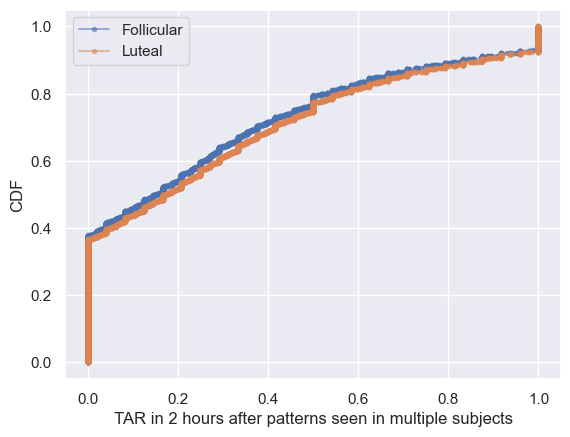

In [157]:
phases = [2, 4]
for phase in phases:
    x, y = ecdf(all_patt_phases_stats[(all_patt_phases_stats['cgm_mean'].notnull()) & (all_patt_phases_stats['phase'] == phase)]['tar_mean'])
    plt.plot(x, y, '.-', alpha = .5);
plt.xlabel('TAR in 2 hours after patterns seen in multiple subjects')
plt.ylabel('CDF')
plt.legend(['Follicular', 'Luteal']);

### Significance testing

In [158]:
def two_tailed_same_mean_permutation_test(data1, data2, num_reps=10000):
    """ Returns the p-value regarding the null hypothesis that the two
    arrays have the same mean"""
    #get original value
    orig_test = np.mean(data1) - np.mean(data2)
    
    #combining, declaring list
    test_list = np.zeros(10000)
    
    combined = np.concatenate([data1, data2])
    #half = int(len(combined) / 2)
    
    #permuting, getting list of test stats
    for i in range(10000):
        permuted = np.random.permutation(combined)
        samp_1 = permuted[:(len(data1))]
        samp_2 = permuted[(len(data1)):]
        test_stat = np.mean(samp_1) - np.mean(samp_2)
        test_list[i] = test_stat

    #calculate p value
    count = 0
    for i in range(len(test_list)):
        if (test_list[i] >= orig_test) or (test_list[i] <= -orig_test):
            count += 1
        
    p_value = count / 10000

    return p_value

In [160]:
two_tailed_same_mean_permutation_test((all_patt_phases_stats[(all_patt_phases_stats['cgm_mean'].notnull()) & (all_patt_phases_stats['phase'] == 4)]['cgm_mean']), 
(all_patt_phases_stats[(all_patt_phases_stats['cgm_mean'].notnull()) & (all_patt_phases_stats['phase'] == 2)]['cgm_mean']))

0.024

# Phase division outcome analysis


In [162]:
patt_arr = []
patt_str = all_patt_phases_stats['patt'].unique()
for i in range(len(patt_str)):
    patt_arr.append(ast.literal_eval(all_patt_phases_stats['patt'].unique()[i]))

## Adding cols for bolus/carb presence

In [163]:
all_patt_phases_stats.iloc[0]['patt']

"['500030005', '500030005', '500030005', '500030005']"

In [164]:
has_bolus_list = []
bolus_vals_list = []
has_carbs_list = []
carbs_vals_list = []
missing_data_list = []
data_vals_list = []

# for each pattern
for patt in all_patt_phases_stats['patt'].unique():
    # get blocks
    blocks_included = ast.literal_eval(patt)

    has_bolus = 0
    bolus_vals = ''
    has_carbs = 0
    carbs_vals = ''
    missing_data = 0
    data_vals = ''

    # if bolus or carb block nonzero, make has value true and add val to vals string
    for block in blocks_included:
        if block[5] != '0':
            has_bolus = 1
            bolus_vals = bolus_vals + str(block[5])
        if block[7] != '0':
            has_carbs = 1
            carbs_vals = carbs_vals + str(block[7])
        if block[8] != '5':
            missing_data = 1
            data_vals = data_vals + str(block[8])

    # times however many rows in pattern
    for i in range(len(all_patt_phases_stats[all_patt_phases_stats['patt'] == patt])):
        has_bolus_list.append(has_bolus)
        bolus_vals_list.append(bolus_vals)
        has_carbs_list.append(has_carbs)
        carbs_vals_list.append(carbs_vals)
        missing_data_list.append(missing_data)
        data_vals_list.append(data_vals)

# set columns
all_patt_phases_stats['has_bolus'] = has_bolus_list
all_patt_phases_stats['bolus_vals'] = bolus_vals_list
all_patt_phases_stats['has_carbs'] = has_carbs_list
all_patt_phases_stats['carbs_vals'] = carbs_vals_list
all_patt_phases_stats['has_missing_data'] = missing_data_list
all_patt_phases_stats['missing_data_vals'] = data_vals_list

In [165]:
all_patt_phases_stats['missing_data_vals'].unique()

array(['', '0', '3', '00', '4', '000', '1', '02', '00000000000', '000000',
       '0000', '0000000000', '00000000', '00000', '000000000', '0000000',
       '000000000000', '0000000000000', '00000000000000',
       '000000000000000000', '00000000000000000',
       '0000000000000000000000000000', '00000000000000000000',
       '0000000000000000', '000000000000000000000000000',
       '0000000000000000000', '000000000000000',
       '00000000000000000000000000', '0000000000000000000000000',
       '000000000000000000000000', '00000000000000000000000',
       '0000000000000000000000', '000000000000000000000',
       '0000000000000000000000000000000000',
       '000000000000000000000000000000000',
       '00000000000000000000000000000000',
       '0000000000000000000000000000000',
       '000000000000000000000000000000', '00000000000000000000000000000',
       '2',
       '000000000000000000000000000000000000000000000000000000000000000000000000',
       '000000000000000000000000000000000000

In [166]:
def get_risk_stats(df):
    ''' get risk values for dataframes based on all_patt_phases_stats structure'''
    data = []

    for patt in df['patt'].unique():

        slice = df[df['patt'] == patt] # get all phase rows for a pattern

        # get patt, length, unique blocks, # unique blocks, incl low/high/food, seen subj ids, % subj, num subj
        row = np.append(slice.iloc[0].to_numpy()[:4], (slice.iloc[0].to_numpy()[5:11]))

        # if pattern exists in both FP and LP
        if ((len(slice[slice['phase'] == 2]) > 0) & (len(slice[slice['phase'] == 4]) > 0)):

            # getting total difference in risk: combined risk in LP - combined risk in FP
            tot_risk_diff = slice[slice['phase'] == 4].iloc[0]['tot_risk'] - slice[slice['phase'] == 2].iloc[0]['tot_risk']

            # getting percent difference in total risk: (combined risk in LP - combined risk in FP) / combined risk in FP 
            if slice[slice['phase'] == 2].iloc[0]['tot_risk'] != 0: # check FP value is not 0
                tot_risk_perc_diff = ((slice[slice['phase'] == 4].iloc[0]['tot_risk'] - slice[slice['phase'] == 2].iloc[0]['tot_risk']) 
                            / (slice[slice['phase'] == 2].iloc[0]['tot_risk']))
            else:
                tot_risk_perc_diff = np.nan
            
            # getting difference in low risk: lbgi in LP - lbgi in FP
            lbgi_risk_diff = slice[slice['phase'] == 4].iloc[0]['lbgi_mean_risk'] - slice[slice['phase'] == 2].iloc[0]['lbgi_mean_risk']

            # getting percent difference in low risk: (lbgi in LP - lbgi in FP) / lbgi in FP 
            if slice[slice['phase'] == 2].iloc[0]['lbgi_mean_risk'] != 0: # check FP value is not 0
                lbgi_risk_perc_diff = ((slice[slice['phase'] == 4].iloc[0]['lbgi_mean_risk'] - slice[slice['phase'] == 2].iloc[0]['lbgi_mean_risk']) 
                            / (slice[slice['phase'] == 2].iloc[0]['lbgi_mean_risk']))
            else:
                lbgi_risk_perc_diff = np.nan
            
            # getting difference in high risk: hbgi in LP - hbgi in FP
            hbgi_risk_diff = slice[slice['phase'] == 4].iloc[0]['hbgi_mean_risk'] - slice[slice['phase'] == 2].iloc[0]['hbgi_mean_risk']

            # getting percent difference in high risk: (hbgi in LP - hbgi in FP) / hbgi in FP 
            if slice[slice['phase'] == 2].iloc[0]['hbgi_mean_risk'] != 0: # check FP value is not 0
                hbgi_risk_perc_diff = ((slice[slice['phase'] == 4].iloc[0]['hbgi_mean_risk'] - slice[slice['phase'] == 2].iloc[0]['hbgi_mean_risk']) 
                            / (slice[slice['phase'] == 2].iloc[0]['hbgi_mean_risk']))
            else: 
                hbgi_risk_perc_diff = np.nan
            
            vars_to_add = [tot_risk_diff, tot_risk_perc_diff, lbgi_risk_diff, lbgi_risk_perc_diff, hbgi_risk_diff, hbgi_risk_perc_diff]

            row = np.append(row, vars_to_add)

            data.append(row)

    col_arr = ['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'incl_low', 'incl_high', 'incl_food', 
               'seen_subj_ids', 'perc_subj_seen', 'num_subj', 'total_risk_diff', 'perc_total_risk_diff',
               'lbgi_risk_diff', 'perc_lbgi_risk_diff', 'hbgi_risk_diff', 'perc_hbgi_risk_diff']  
    risk_df = pd.DataFrame(data, columns = col_arr)

    return risk_df

### Carbs and bolus

In [167]:
# get dataframes with carbs & bolus, only bolus, and only carbs
carbs_and_bolus_df = all_patt_phases_stats[(all_patt_phases_stats['has_bolus'] == 1) & (all_patt_phases_stats['has_carbs'] == 1)]
only_bolus_df = all_patt_phases_stats[(all_patt_phases_stats['has_bolus'] == 1) & (all_patt_phases_stats['has_carbs'] == 0)]
only_carbs_df = all_patt_phases_stats[(all_patt_phases_stats['has_bolus'] == 0) & (all_patt_phases_stats['has_carbs'] == 1)]

In [217]:
print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 2]['tot_risk'].mean())
print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 4]['tot_risk'].mean())

print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 2]['lbgi_mean_risk'].mean())
print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 4]['lbgi_mean_risk'].mean())

print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 2]['hbgi_mean_risk'].mean())
print(carbs_and_bolus_df[carbs_and_bolus_df['phase'] == 4]['hbgi_mean_risk'].mean())

9.073816489826648
8.562555645139897
1.876112435833452
1.957691924287599
7.1977040539931965
6.604863720852299


### Only bolus

#### Overall

In [224]:
len(only_bolus_df['patt'].unique())

1139

In [218]:
# looking at overall mean risk values
print(only_bolus_df[only_bolus_df['phase'] == 2]['tot_risk'].mean())
print(only_bolus_df[only_bolus_df['phase'] == 4]['tot_risk'].mean())

print(only_bolus_df[only_bolus_df['phase'] == 2]['lbgi_mean_risk'].mean())
print(only_bolus_df[only_bolus_df['phase'] == 4]['lbgi_mean_risk'].mean())

print(only_bolus_df[only_bolus_df['phase'] == 2]['hbgi_mean_risk'].mean())
print(only_bolus_df[only_bolus_df['phase'] == 4]['hbgi_mean_risk'].mean())

7.424890069363684
7.523188366534322
2.3755160935766932
2.2288896480083027
5.04937397578699
5.2942987185260195


In [240]:
only_bolus_df['bolus_vals'].unique()

array(['5', '55', '555', '5555', '4', '3', '5555555', '1', '2', '13',
       '11', '45', '51', '551', '155', '153', '21', '15', '35', '1155',
       '141', '31', '414', '52', '511', '41', '355', '54', '53', '1555',
       '333', '33', '515', '455', '443', '351', '111', '23', '554', '521',
       '313', '545', '553'], dtype=object)

#### Bolus = 5

In [221]:
bolus_5_df = only_bolus_df[only_bolus_df['bolus_vals'] == '5']
len(bolus_5_df)

1225

In [222]:
bolus_5_risk = get_risk_stats(bolus_5_df)

In [241]:
bolus_5_risk.mean()

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/2609038217.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bolus_5_risk.mean()


length                  4.617284
num_unique_blocks       2.514403
incl_low                0.000000
incl_high               0.427984
incl_food               0.000000
perc_subj_seen          0.060905
num_subj                1.827160
total_risk_diff         0.766298
perc_total_risk_diff    1.504024
lbgi_risk_diff         -0.454554
perc_lbgi_risk_diff     0.389221
hbgi_risk_diff          1.220852
perc_hbgi_risk_diff     0.907689
dtype: float64

Look into more - 38% increase in LBGI risk, but 150% in HBGI risk in patterns with 1 large bolus

#### Bolus = 3

In [225]:
bolus_3_df = only_bolus_df[only_bolus_df['bolus_vals'] == '3']
len(bolus_3_df)

94

In [226]:
bolus_3_risk = get_risk_stats(bolus_3_df)

In [239]:
bolus_3_risk.mean()

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/1073398214.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bolus_3_risk.mean()


length                  3.611111
num_unique_blocks       2.277778
incl_low                0.000000
incl_high               0.222222
incl_food               0.000000
perc_subj_seen          0.050000
num_subj                1.500000
total_risk_diff         1.899993
perc_total_risk_diff    1.744001
lbgi_risk_diff          1.193712
perc_lbgi_risk_diff     1.695961
hbgi_risk_diff          0.706281
perc_hbgi_risk_diff     9.392262
dtype: float64

#### Bolus = 1

In [227]:
bolus_1_df = only_bolus_df[only_bolus_df['bolus_vals'] == '1']
len(bolus_1_df)

192

In [228]:
bolus_1_risk = get_risk_stats(bolus_1_df)

### Only carbs

#### Overall

In [229]:
len(only_carbs_df['patt'].unique())

579

In [231]:
# mean risk values - overall increase in risk with carb intake?
print(only_carbs_df[only_carbs_df['phase'] == 2]['tot_risk'].mean())
print(only_carbs_df[only_carbs_df['phase'] == 4]['tot_risk'].mean())

print(only_carbs_df[only_carbs_df['phase'] == 2]['lbgi_mean_risk'].mean())
print(only_carbs_df[only_carbs_df['phase'] == 4]['lbgi_mean_risk'].mean())

print(only_carbs_df[only_carbs_df['phase'] == 2]['hbgi_mean_risk'].mean())
print(only_carbs_df[only_carbs_df['phase'] == 4]['hbgi_mean_risk'].mean())

7.161111065329703
9.87118810695319
2.3009205434664666
2.6244221024228374
4.860190521863238
7.246766004530355


#### Carbs = 5

In [232]:
carbs_5_df = only_carbs_df[only_carbs_df['carbs_vals'] == '5']
len(carbs_5_df)

1129

In [233]:
carbs_5_risk = get_risk_stats(carbs_5_df)

In [234]:
carbs_5_risk.mean()

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/3388904727.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  carbs_5_risk.mean()


length                  8.700658
num_unique_blocks       2.319079
incl_low                0.131579
incl_high               0.253289
incl_food               1.000000
perc_subj_seen          0.039145
num_subj                1.174342
total_risk_diff         2.640250
perc_total_risk_diff    3.578508
lbgi_risk_diff          0.355478
perc_lbgi_risk_diff     1.281704
hbgi_risk_diff          2.284772
perc_hbgi_risk_diff     1.935213
dtype: float64

#### Carbs = 55

In [236]:
carbs_55_df = only_carbs_df[only_carbs_df['carbs_vals'] == '55']

In [237]:
carbs_55_risk = get_risk_stats(carbs_55_df)

In [238]:
carbs_55_risk.mean()

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/1777467173.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  carbs_55_risk.mean()


length                  1.050000e+01
num_unique_blocks       2.125000e+00
incl_low                1.250000e-01
incl_high               1.250000e-01
incl_food               1.000000e+00
seen_subj_ids           9.764723e+38
perc_subj_seen          3.333333e-02
num_subj                1.000000e+00
total_risk_diff        -1.352962e+00
perc_total_risk_diff    9.616994e-02
lbgi_risk_diff         -5.124884e-01
perc_lbgi_risk_diff    -2.715757e-02
hbgi_risk_diff         -8.404739e-01
perc_hbgi_risk_diff    -3.158343e-01
dtype: float64

# Pattern outcome specificity

In [62]:
all_patt_phases_stats.columns

Index(['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'phase',
       'incl_low', 'incl_high', 'incl_food', 'seen_subj_ids', 'perc_subj_seen',
       'num_subj', 'avg_repeats', 'min_repeats', 'max_repeats', 'tot_repeats',
       'tot_outcomes', 'tot_lows', 'perc_lows', 'tot_highs', 'perc_highs',
       'tot_vhighs', 'perc_vhighs', 'cgm_mean', 'lbgi_mean', 'lbgi_mean_risk',
       'hbgi_mean', 'hbgi_mean_risk', 'tir_mean', 'tbr_mean', 'tar_mean',
       'tvar_mean', 'abs_min_val', 'abs_max_val', 'avg_min_val', 'avg_max_val',
       'avg_min_time', 'avg_max_time', 'end_cgm', 'tot_risk', 'has_bolus',
       'bolus_vals', 'has_carbs', 'carbs_vals', 'has_missing_data',
       'missing_data_vals'],
      dtype='object')

### Revamping high/low specificity into 1 df instead of 2 and then merging

In [260]:
# still working on tidying this up
data_to_track = []
patt_arr = all_patt_phases_stats['patt'].unique()
for i in range(len(patt_arr)):
    singlepatt = all_patt_phases_stats[all_patt_phases_stats['patt'] == str(patt_arr[i])].copy()

    has_follicular_low_perc = singlepatt[singlepatt['phase'] == 2]['perc_lows'].notnull().values.flatten()
    has_luteal__low_perc = singlepatt[singlepatt['phase'] == 4]['perc_lows'].notnull().values.flatten()

    has_follicular_high_perc = singlepatt[singlepatt['phase'] == 2]['perc_highs'].notnull().values.flatten()
    has_luteal_high_perc = singlepatt[singlepatt['phase'] == 4]['perc_highs'].notnull().values.flatten()

    patt = singlepatt.iloc[0]['patt']
    length = singlepatt.iloc[0]['length']
    unique_blocks = singlepatt.iloc[0]['unique_blocks']
    num_unique_blocks = singlepatt.iloc[0]['num_unique_blocks']
    num_subj = singlepatt.iloc[0]['num_subj']
    subj_seen = singlepatt.iloc[0]['seen_subj_ids']
    f_tot_outcomes = (singlepatt[singlepatt['phase'] == 2]['tot_outcomes'].values.flatten())
    f_low_perc = (singlepatt[singlepatt['phase'] == 2]['perc_lows'].values.flatten())
    f_high_perc = (singlepatt[singlepatt['phase'] == 2]['perc_highs'].values.flatten())
    f_cgm_mean = (singlepatt[singlepatt['phase'] == 2]['cgm_mean'].values.flatten())
    f_avg_min_val = (singlepatt[singlepatt['phase'] == 2]['avg_min_val'].values.flatten())
    f_avg_max_val = (singlepatt[singlepatt['phase'] == 2]['avg_max_val'].values.flatten())
    f_avg_min_time = (singlepatt[singlepatt['phase'] == 2]['avg_min_time'].values.flatten())
    f_avg_max_time = (singlepatt[singlepatt['phase'] == 2]['avg_max_time'].values.flatten())
    f_end_cgm = (singlepatt[singlepatt['phase'] == 2]['end_cgm'].values.flatten())
    l_tot_outcomes = (singlepatt[singlepatt['phase'] == 4]['tot_outcomes'].values.flatten())
    l_low_perc = (singlepatt[singlepatt['phase'] == 4]['perc_lows'].values.flatten())
    l_high_perc = (singlepatt[singlepatt['phase'] == 4]['perc_highs'].values.flatten())
    l_cgm_mean = (singlepatt[singlepatt['phase'] == 4]['cgm_mean'].values.flatten())
    l_avg_min_val = (singlepatt[singlepatt['phase'] == 4]['avg_min_val'].values.flatten())
    l_avg_max_val = (singlepatt[singlepatt['phase'] == 4]['avg_max_val'].values.flatten())
    l_avg_min_time = (singlepatt[singlepatt['phase'] == 4]['avg_min_time'].values.flatten())
    l_avg_max_time = (singlepatt[singlepatt['phase'] == 4]['avg_max_time'].values.flatten())
    l_end_cgm = (singlepatt[singlepatt['phase'] == 4]['end_cgm'].values.flatten())

    data_to_track.append([patt, length, unique_blocks, num_unique_blocks, num_subj, subj_seen, 
                          f_tot_outcomes, f_low_perc, f_high_perc, f_cgm_mean,
                          f_avg_min_val, f_avg_max_val, f_avg_min_time, f_avg_max_time, f_end_cgm,
                          l_tot_outcomes, l_low_perc, l_high_perc, l_cgm_mean,
                          l_avg_min_val, l_avg_max_val, l_avg_min_time, l_avg_max_time, l_end_cgm])
    
columns = ['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'num_subj', 'subj_seen', 
           'f_tot_outcomes', 'f_low_perc', 'f_high_perc', 'f_cgm_mean', 
           'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time', 'f_end_cgm',
           'l_tot_outcomes', 'l_low_perc', 'l_high_perc', 'l_cgm_mean', 
           'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time', 'l_end_cgm']
    
outcome_split_v2_df = pd.DataFrame(data = data_to_track, columns = columns)

### high specificity

In [243]:
high_perc_data = []
for i in range(len(patt_arr)):
    # get patterns that have some non-null value (can be 0) for percent highs in both phases - makes sure pattern exists in both FP and LP
    singlepatt = all_patt_phases_stats[all_patt_phases_stats['patt'] == str(patt_arr[i])].copy()

    has_follicular_perc = singlepatt[singlepatt['phase'] == 2]['perc_highs'].notnull().values.flatten()
    has_luteal_perc = singlepatt[singlepatt['phase'] == 4]['perc_highs'].notnull().values.flatten()

    # get pattern info
    patt = singlepatt.iloc[0]['patt']
    length = singlepatt.iloc[0]['length']
    unique_blocks = singlepatt.iloc[0]['unique_blocks']
    num_unique_blocks = singlepatt.iloc[0]['num_unique_blocks']
    num_subj = singlepatt.iloc[0]['num_subj']
    subj_seen = singlepatt.iloc[0]['seen_subj_ids']

    # adding other statistics from FP and LP
    if has_follicular_perc and has_luteal_perc:
        high_perc_data.append([patt, length, unique_blocks, num_unique_blocks, num_subj, subj_seen,
                                  (singlepatt[singlepatt['phase'] == 2]['perc_highs'].values.flatten())[0], 
                                  (singlepatt[singlepatt['phase'] == 2]['tot_outcomes'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['cgm_mean'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_min_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_max_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_min_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_max_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['end_cgm'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['perc_highs'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['tot_outcomes'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['cgm_mean'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_min_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_max_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_min_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_max_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['end_cgm'].values.flatten())[0]])
        
high_perc_df = pd.DataFrame(high_perc_data, columns=['patt', 'length', 'unique_blocks', 'num_unique_blocks',
                                                     'num_subj', 'seen_subj_ids',
                                                     'f_perc_high_outcomes', 'f_num_outcomes', 'f_mean_cgm', 
                                                     'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time', 'f_end_cgm',
                                                     'l_perc_high_outcomes', 'l_num_outcomes', 'l_mean_cgm',
                                                     'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time', 'l_end_cgm'])

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/2335456160.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if has_follicular_perc and has_luteal_perc:


In [67]:
high_perc_df.to_csv('phase_split_high_outcomes.csv')

In [246]:
len(high_perc_df)

3287

### low specificity

In [175]:
low_perc_data = []
for i in range(len(patt_arr)):
    # get patterns that have some non-null value (can be 0) for percent lows in both phases - makes sure pattern exists in both FP and LP
    singlepatt = all_patt_phases_stats[all_patt_phases_stats['patt'] == str(patt_arr[i])].copy()
    has_follicular_perc = singlepatt[singlepatt['phase'] == 2]['perc_lows'].notnull().values.flatten()
    has_luteal_perc = singlepatt[singlepatt['phase'] == 4]['perc_lows'].notnull().values.flatten()

    # get pattern info
    patt = singlepatt.iloc[0]['patt']
    length = singlepatt.iloc[0]['length']
    unique_blocks = singlepatt.iloc[0]['unique_blocks']
    num_unique_blocks = singlepatt.iloc[0]['num_unique_blocks']
    num_subj = singlepatt.iloc[0]['num_subj']
    subj_seen = singlepatt.iloc[0]['seen_subj_ids']

    # adding other statistics from FP and LP
    if has_follicular_perc and has_luteal_perc:
        low_perc_data.append(([patt, length, unique_blocks, num_unique_blocks, num_subj, subj_seen,
                                  (singlepatt[singlepatt['phase'] == 2]['perc_lows'].values.flatten())[0], 
                                  (singlepatt[singlepatt['phase'] == 2]['tot_outcomes'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['cgm_mean'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_min_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_max_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_min_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['avg_max_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 2]['end_cgm'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['perc_lows'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['tot_outcomes'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['cgm_mean'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_min_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_max_val'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_min_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['avg_max_time'].values.flatten())[0],
                                  (singlepatt[singlepatt['phase'] == 4]['end_cgm'].values.flatten())[0],]))
        
low_perc_df = pd.DataFrame(low_perc_data, columns=['patt', 'length', 'unique_blocks', 'num_unique_blocks',
                                                   'num_subj', 'seen_subj_ids',
                                                   'f_perc_low_outcomes', 'f_num_outcomes', 'f_mean_cgm',
                                                   'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time', 'f_end_cgm',
                                                   'l_perc_low_outcomes', 'l_num_outcomes', 'l_mean_cgm',
                                                   'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time', 'l_end_cgm'])

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/132855621.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if has_follicular_perc and has_luteal_perc:


In [177]:
low_perc_df[(low_perc_df['f_perc_low_outcomes']!= 0) | (low_perc_df['l_perc_low_outcomes']!=0)]

,patt,length,unique_blocks,num_unique_blocks,num_subj,seen_subj_ids,f_perc_low_outcomes,f_num_outcomes,f_mean_cgm,f_avg_min_val,...,f_avg_max_time,f_end_cgm,l_perc_low_outcomes,l_num_outcomes,l_mean_cgm,l_avg_min_val,l_avg_max_val,l_avg_min_time,l_avg_max_time,l_end_cgm
0,"['500030005', '500030005', '500030005', '50003...",4,"[""'500030005'""]",1,3,"[78117, 78113, 78108]",0.054054,666,159.662206,139.748050,...,84.643164,158.912036,0.030612,882,164.526357,143.201196,185.404759,90.860156,68.732494,164.113120
1,"['500030005', '500030005', '500030005', '50003...",6,"[""'500030005'""]",1,3,"[78117, 78113, 78108]",0.065678,472,158.081698,138.381515,...,61.867427,157.814001,0.026104,498,169.432400,147.206946,191.330578,81.904841,84.710354,169.892916
2,"['500030005', '500030005', '500030005', '50003...",8,"[""'500030005'""]",1,3,"[78117, 78113, 78108]",0.061290,310,151.813319,131.356108,...,99.102686,152.291011,0.026738,374,171.208661,148.715251,192.675553,107.511855,81.710137,169.978209
4,"['105040005', '105040005', '105040005', '10504...",4,"[""'105040005'""]",1,3,"[78117, 78113, 78108]",0.100000,10,153.477073,127.171053,...,42.500000,181.078947,0.000000,16,132.782895,119.460526,148.605263,49.736842,57.894737,129.552632
5,"['500030005', '500030005', '500030005', '50003...",12,"[""'500030005'""]",1,3,"[78117, 78113, 78108]",0.050725,138,147.335267,126.208334,...,92.572948,146.999672,0.032967,182,175.561594,152.821830,197.134884,78.470774,98.234510,175.743466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266,"['105045405', '105040305', '105045305']",3,"[""'105040305'"", ""'105045305'"", ""'105045405'""]",3,1,[78105],0.500000,2,84.458333,74.500000,...,0.000000,76.500000,0.000000,2,119.583333,97.500000,129.500000,0.000000,20.000000,129.500000
3268,"['105040305', '500030305', '500030205']",3,"[""'105040305'"", ""'500030205'"", ""'500030305'""]",3,1,[78132],0.166667,6,119.097222,101.833333,...,58.333333,123.000000,0.000000,2,135.708333,132.000000,138.500000,10.000000,20.000000,138.000000
3273,"['105041505', '105040305', '500030305']",3,"[""'105040305'"", ""'105041505'"", ""'500030305'""]",3,1,[78132],0.000000,4,121.416667,116.250000,...,57.500000,126.000000,0.500000,2,84.041667,71.000000,91.500000,45.000000,30.000000,81.500000
3281,"['500030105', '304033505', '105043505']",3,"[""'105043505'"", ""'304033505'"", ""'500030105'""]",3,1,[78132],0.500000,2,92.666667,73.500000,...,55.000000,90.500000,0.000000,2,109.125000,105.500000,113.500000,30.000000,55.000000,108.000000


In [72]:
low_perc_df.to_csv('phase_split_low_outcomes.csv')

In [178]:
len(low_perc_df)

3287

In [180]:
all_patt_phases_stats.sort_values('lbgi_mean_risk', ascending=False)

,patt,length,unique_blocks,num_unique_blocks,phase,incl_low,incl_high,incl_food,seen_subj_ids,perc_subj_seen,...,avg_min_time,avg_max_time,end_cgm,tot_risk,has_bolus,bolus_vals,has_carbs,carbs_vals,has_missing_data,missing_data_vals
9796,"['500030305', '500035505', '500030505']",3,"[""'500030305'"", ""'500030505'"", ""'500035505'""]",3,2,False,False,False,"[78124, 78126]",0.066667,...,5.0,0.0,65.5,25.893001,1,5,0,,0,
13246,"['500030505', '500035505', '500030305', '50003...",4,"[""'500030105'"", ""'500030305'"", ""'500030505'"", ...",4,1,False,False,False,[78126],0.033333,...,75.0,70.0,59.0,20.994151,1,5,0,,0,
13153,"['500035505', '500030305', '500030105']",3,"[""'500030105'"", ""'500030305'"", ""'500035505'""]",3,1,False,False,False,[78126],0.033333,...,75.0,70.0,59.0,20.994151,1,5,0,,0,
8314,"['500030305', '500030305', '500030305', '50003...",6,"[""'500030305'"", ""'500030355'""]",2,2,False,False,True,[78136],0.033333,...,55.0,0.0,50.0,20.450726,0,,1,5,0,
12253,"['500030305', '500030305', '500031505']",3,"[""'500030305'"", ""'500031505'""]",2,2,False,False,False,[78130],0.033333,...,55.0,0.0,52.5,19.311926,1,1,0,,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14691,"['105040005', '105540005', '303030005', '50003...",4,"[""'105040005'"", ""'105540005'"", ""'303030005'"", ...",4,4,False,True,False,[78108],0.033333,...,NaN,NaN,NaN,NaN,0,,0,,0,
14695,"['105040005', '304030005', '500030005', '50003...",5,"[""'105040005'"", ""'304030005'"", ""'500030005'""]",3,4,False,True,False,[78108],0.033333,...,NaN,NaN,NaN,NaN,0,,0,,0,
14696,"['303030005', '500030005', '500030005', '50003...",18,"[""'303030005'"", ""'500030005'""]",2,4,False,True,False,[78108],0.033333,...,NaN,NaN,NaN,NaN,0,,0,,0,
14707,"['500030005', '500030005', '500030005', '50003...",9,"[""'500030004'"", ""'500030005'""]",2,4,False,False,False,[78108],0.033333,...,NaN,NaN,NaN,NaN,0,,0,,1,4


### Combining low/high outcome splits

In [181]:
# making subj id arrays strings for merging
high_perc_df['seen_subj_ids'] = high_perc_df['seen_subj_ids'].apply(str)
low_perc_df['seen_subj_ids'] = low_perc_df['seen_subj_ids'].apply(str)

In [183]:
low_perc_df.iloc[0]['seen_subj_ids']

"['78117' '78113' '78108']"

In [184]:
outcome_split_df = pd.merge(low_perc_df, high_perc_df, on = ['patt', 'length','unique_blocks', 'num_unique_blocks', 'num_subj', 'seen_subj_ids', 
                                                             'f_num_outcomes', 'f_mean_cgm', 'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time', 'f_end_cgm',
                                                             'l_num_outcomes', 'l_mean_cgm', 'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time', 'l_end_cgm'])

In [189]:
# excluding patterns with 1 unique block or '000000000' blocks
outcome_split_df = outcome_split_df[outcome_split_df['num_unique_blocks'] > 1]
outcome_split_df = outcome_split_df[~outcome_split_df['unique_blocks'].str.contains('000000000')].copy()

In [79]:
outcome_split_df.to_csv('phase_split_all_outcomes.csv')

In [188]:
outcome_split_df['high_diff']= outcome_split_df['l_perc_high_outcomes'] - outcome_split_df['f_perc_high_outcomes']
outcome_split_df['low_diff']= outcome_split_df['l_perc_low_outcomes'] - outcome_split_df['f_perc_low_outcomes']

In [81]:
# splitting into patterns that had lows and patterns that had highs - removing patterns with 0 high outcomes in high df and vice versa
outcome_split_has_lows = outcome_split_df[(outcome_split_df['f_perc_low_outcomes']!= 0) | (outcome_split_df['l_perc_low_outcomes']!= 0)].copy()
outcome_split_has_highs = outcome_split_df[(outcome_split_df['f_perc_high_outcomes']!= 0) | (outcome_split_df['l_perc_high_outcomes']!= 0)].copy()

In [191]:
high_50_perc = outcome_split_has_highs[(outcome_split_has_highs['high_diff'] >= .5) | (outcome_split_has_highs['high_diff'] <= -.5)]
low_50_perc = outcome_split_has_lows[(outcome_split_has_lows['low_diff'] >= .5) | (outcome_split_has_lows['low_diff'] <= -.5)]

### diffs outputs

In [192]:
diffs_list = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
for diff in diffs_list:
    patterns_in_diff = outcome_split_has_highs[(outcome_split_has_highs['high_diff'] >= diff) | 
                                               (outcome_split_has_highs['high_diff'] <= -diff)]
    num_patterns_in_crit = len(patterns_in_diff[(patterns_in_diff['f_num_outcomes'] >= 3) & (patterns_in_diff['l_num_outcomes'] >= 3)])
    print('criteria: 3 occurrences, ', diff, ' difference. num patterns = ', num_patterns_in_crit)

criteria: 3 occurrences,  0.05  difference. num patterns =  468
criteria: 3 occurrences,  0.1  difference. num patterns =  395
criteria: 3 occurrences,  0.15  difference. num patterns =  327
criteria: 3 occurrences,  0.2  difference. num patterns =  271
criteria: 3 occurrences,  0.25  difference. num patterns =  231
criteria: 3 occurrences,  0.3  difference. num patterns =  161
criteria: 3 occurrences,  0.35  difference. num patterns =  115
criteria: 3 occurrences,  0.4  difference. num patterns =  99
criteria: 3 occurrences,  0.45  difference. num patterns =  75
criteria: 3 occurrences,  0.5  difference. num patterns =  70
criteria: 3 occurrences,  0.55  difference. num patterns =  33
criteria: 3 occurrences,  0.6  difference. num patterns =  28
criteria: 3 occurrences,  0.65  difference. num patterns =  20
criteria: 3 occurrences,  0.7  difference. num patterns =  15
criteria: 3 occurrences,  0.75  difference. num patterns =  14
criteria: 3 occurrences,  0.8  difference. num patterns

In [193]:
for diff in diffs_list:
    patterns_in_diff = outcome_split_has_highs[(outcome_split_has_highs['high_diff'] >= diff) | 
                                               (outcome_split_has_highs['high_diff'] <= -diff)]
    num_patterns_in_crit = len(patterns_in_diff[(patterns_in_diff['f_num_outcomes'] >= 5) & (patterns_in_diff['l_num_outcomes'] >= 5)])
    print('criteria: 5 occurrences, ', diff, ' difference. num patterns = ', num_patterns_in_crit)

criteria: 5 occurrences,  0.05  difference. num patterns =  318
criteria: 5 occurrences,  0.1  difference. num patterns =  261
criteria: 5 occurrences,  0.15  difference. num patterns =  201
criteria: 5 occurrences,  0.2  difference. num patterns =  154
criteria: 5 occurrences,  0.25  difference. num patterns =  118
criteria: 5 occurrences,  0.3  difference. num patterns =  79
criteria: 5 occurrences,  0.35  difference. num patterns =  52
criteria: 5 occurrences,  0.4  difference. num patterns =  39
criteria: 5 occurrences,  0.45  difference. num patterns =  24
criteria: 5 occurrences,  0.5  difference. num patterns =  20
criteria: 5 occurrences,  0.55  difference. num patterns =  8
criteria: 5 occurrences,  0.6  difference. num patterns =  5
criteria: 5 occurrences,  0.65  difference. num patterns =  4
criteria: 5 occurrences,  0.7  difference. num patterns =  3
criteria: 5 occurrences,  0.75  difference. num patterns =  2
criteria: 5 occurrences,  0.8  difference. num patterns =  1
c

In [194]:
for diff in diffs_list:
    patterns_in_diff = outcome_split_has_lows[(outcome_split_has_lows['low_diff'] >= diff) | 
                                               (outcome_split_has_lows['low_diff'] <= -diff)]
    num_patterns_in_crit = len(patterns_in_diff[(patterns_in_diff['f_num_outcomes'] >= 3) & (patterns_in_diff['l_num_outcomes'] >= 3)])
    print('criteria: 3 occurrences, ', diff, ' difference. num patterns = ', num_patterns_in_crit)

criteria: 3 occurrences,  0.05  difference. num patterns =  188
criteria: 3 occurrences,  0.1  difference. num patterns =  141
criteria: 3 occurrences,  0.15  difference. num patterns =  77
criteria: 3 occurrences,  0.2  difference. num patterns =  48
criteria: 3 occurrences,  0.25  difference. num patterns =  41
criteria: 3 occurrences,  0.3  difference. num patterns =  16
criteria: 3 occurrences,  0.35  difference. num patterns =  9
criteria: 3 occurrences,  0.4  difference. num patterns =  6
criteria: 3 occurrences,  0.45  difference. num patterns =  6
criteria: 3 occurrences,  0.5  difference. num patterns =  6
criteria: 3 occurrences,  0.55  difference. num patterns =  1
criteria: 3 occurrences,  0.6  difference. num patterns =  1
criteria: 3 occurrences,  0.65  difference. num patterns =  1
criteria: 3 occurrences,  0.7  difference. num patterns =  1
criteria: 3 occurrences,  0.75  difference. num patterns =  1
criteria: 3 occurrences,  0.8  difference. num patterns =  1
criteria

In [195]:
for diff in diffs_list:
    patterns_in_diff = outcome_split_has_lows[(outcome_split_has_lows['low_diff'] >= diff) | 
                                               (outcome_split_has_lows['low_diff'] <= -diff)]
    num_patterns_in_crit = len(patterns_in_diff[(patterns_in_diff['f_num_outcomes'] >= 5) & (patterns_in_diff['l_num_outcomes'] >= 5)])
    print('criteria: 5 occurrences, ', diff, ' difference. num patterns = ', num_patterns_in_crit)

criteria: 5 occurrences,  0.05  difference. num patterns =  137
criteria: 5 occurrences,  0.1  difference. num patterns =  94
criteria: 5 occurrences,  0.15  difference. num patterns =  42
criteria: 5 occurrences,  0.2  difference. num patterns =  22
criteria: 5 occurrences,  0.25  difference. num patterns =  17
criteria: 5 occurrences,  0.3  difference. num patterns =  9
criteria: 5 occurrences,  0.35  difference. num patterns =  4
criteria: 5 occurrences,  0.4  difference. num patterns =  2
criteria: 5 occurrences,  0.45  difference. num patterns =  2
criteria: 5 occurrences,  0.5  difference. num patterns =  2
criteria: 5 occurrences,  0.55  difference. num patterns =  0
criteria: 5 occurrences,  0.6  difference. num patterns =  0
criteria: 5 occurrences,  0.65  difference. num patterns =  0
criteria: 5 occurrences,  0.7  difference. num patterns =  0
criteria: 5 occurrences,  0.75  difference. num patterns =  0
criteria: 5 occurrences,  0.8  difference. num patterns =  0
criteria: 

In [196]:
high_patterns_of_interest = high_50_perc[(high_50_perc['f_num_outcomes'] >= 5) & (high_50_perc['l_num_outcomes'] >= 5)]

In [67]:
low_30_perc = outcome_split_has_lows[(outcome_split_has_lows['low_diff'] >= .3) | (outcome_split_has_lows['low_diff'] <= -.3)]
low_patterns_of_interest = low_30_perc[(low_30_perc['f_num_outcomes'] >= 3) & (low_30_perc['l_num_outcomes'] >= 3)]

In [197]:
high_patterns_of_interest

,patt,length,unique_blocks,num_unique_blocks,num_subj,seen_subj_ids,f_perc_low_outcomes,f_num_outcomes,f_mean_cgm,f_avg_min_val,...,l_mean_cgm,l_avg_min_val,l_avg_max_val,l_avg_min_time,l_avg_max_time,l_end_cgm,f_perc_high_outcomes,l_perc_high_outcomes,high_diff,low_diff
149,"['500030305', '500030405', '500030405', '50003...",4,"[""'500030305'"", ""'500030405'""]",2,3,['78120' '78109' '78126'],0.000000,8,148.857143,130.642857,...,195.079167,173.900000,210.600000,34.500000,45.500000,190.750000,0.125000,0.833333,0.708333,0.000000
255,"['105550105', '105550105', '105550105', '10555...",5,"[""'105540105'"", ""'105550105'""]",2,2,['78134' '78112'],0.166667,6,158.986111,140.833333,...,107.712963,95.444444,121.055556,63.888889,56.111111,108.555556,0.500000,0.000000,-0.500000,-0.041667
268,"['105040105', '105040105', '105040105', '50003...",5,"[""'105040105'"", ""'500030105'""]",2,3,['78134' '78112' '78130'],0.333333,6,92.261905,73.428571,...,141.107143,130.214286,151.571429,49.642857,38.571429,137.321429,0.000000,0.500000,0.500000,-0.333333
345,"['500030305', '500035355', '500030305', '50003...",5,"[""'500030305'"", ""'500035355'""]",2,3,['78125' '78110' '78111'],0.000000,12,188.247396,175.250000,...,296.398148,262.388889,320.333333,30.555556,19.444444,289.444444,0.333333,1.000000,0.666667,0.000000
383,"['500030305', '500035355', '500030305', '50003...",7,"[""'500030305'"", ""'500035355'""]",2,3,['78125' '78111' '78123'],0.000000,8,192.093254,174.904762,...,112.027778,97.666667,127.666667,76.666667,51.666667,110.166667,0.500000,0.000000,-0.500000,0.000000
432,"['105040305', '500030305', '500035355', '50003...",4,"[""'105040305'"", ""'500030305'"", ""'500035355'""]",3,4,['78125' '78122' '78133' '78110'],0.000000,6,224.151042,204.437500,...,188.017857,174.785714,201.000000,59.285714,11.428571,184.357143,1.000000,0.250000,-0.750000,0.125000
449,"['150030305', '500030305', '500030305', '50003...",4,"[""'150030305'"", ""'500030305'""]",2,4,['78125' '78112' '78136' '78123'],0.000000,6,162.766667,147.400000,...,131.975000,121.800000,141.250000,18.000000,59.500000,137.450000,0.500000,0.000000,-0.500000,0.000000
504,"['105040305', '105040305', '105040305', '10504...",5,"[""'105040305'"", ""'105045355'""]",2,3,['78112' '78133' '78123'],0.000000,6,125.738095,108.857143,...,184.486111,159.833333,208.833333,34.166667,74.166667,198.083333,0.166667,0.750000,0.583333,0.000000
537,"['500030305', '500030305', '303030305', '10504...",4,"[""'105040305'"", ""'303030305'"", ""'500030305'""]",3,3,['78112' '78136' '78123'],0.333333,6,172.369048,130.571429,...,108.071429,87.571429,122.714286,15.714286,37.857143,109.000000,0.500000,0.000000,-0.500000,-0.166667
575,"['500030405', '500030505', '500030505', '50003...",4,"[""'500030405'"", ""'500030505'""]",2,3,['78122' '78118' '78126'],0.000000,8,128.835852,114.423077,...,157.086538,145.173077,166.192308,76.923077,54.615385,161.480769,0.000000,0.500000,0.500000,0.000000


In [69]:
high_patterns_of_interest.to_csv('high_patterns_of_interest.csv')

In [70]:
low_patterns_of_interest.to_csv('low_patterns_of_interest.csv')

# Individual pattern specificity changes

In [198]:
# adding number of outcomes in each phase, total risk values for each phase in individual subj dataframes
for df in phase_div_dfs:
    num_blocks_phases_list = []
    p1_num_outcomes_list = []
    p2_num_outcomes_list = []
    p3_num_outcomes_list = []
    p4_num_outcomes_list = []

    for i in range(len(df)):
        # count blocks
        string = df.iloc[i]['unique_blocks'].replace('"','').replace("'", '"').replace('  ', ',')
        num_blocks_phases_list.append(len(json.loads(string))) 

        # count occurences in each phase
        p1_num_outcomes_list.append(len(json.loads(df.iloc[i]['p1_runs'])))
        p2_num_outcomes_list.append(len(json.loads(df.iloc[i]['p2_runs'])))
        p3_num_outcomes_list.append(len(json.loads(df.iloc[i]['p3_runs'])))
        p4_num_outcomes_list.append(len(json.loads(df.iloc[i]['p4_runs'])))

    # assigning lists to cols
    df['num_unique_blocks'] = num_blocks_phases_list
    df['p1_num_outcomes'] = p1_num_outcomes_list
    df['p2_num_outcomes'] = p2_num_outcomes_list
    df['p3_num_outcomes'] = p3_num_outcomes_list
    df['p4_num_outcomes'] = p4_num_outcomes_list

    # new cols - differences in % of patterns that led to outcome
    df['high_diff_l-f'] = df['p4_high_perc'] - df['p2_high_perc']
    df['low_diff_l-f'] = df['p4_low_perc'] - df['p2_low_perc']

    # new cols - total risk 
    df['p1_tot_risk'] = df['p1_avg_hbgi_risk'] + df['p1_avg_lbgi_risk']
    df['p2_tot_risk'] = df['p2_avg_hbgi_risk'] + df['p2_avg_lbgi_risk']
    df['p3_tot_risk'] = df['p3_avg_hbgi_risk'] + df['p3_avg_lbgi_risk']
    df['p4_tot_risk'] = df['p4_avg_hbgi_risk'] + df['p4_avg_lbgi_risk']
    

In [199]:
# cutting out any patterns with only 1 block or 000000000
phase_div_dfs_updated = []
for df in phase_div_dfs:
    new_df = df[df['num_unique_blocks'] > 1].copy()
    new_df = new_df[~new_df['unique_blocks'].str.contains('000000000')].copy()
    phase_div_dfs_updated.append(new_df)

In [200]:
# adding # of runs in each phase and percent risk change
for df in phase_div_dfs_updated:
    p1_num_list = []
    p2_num_list = []
    p3_num_list = []
    p4_num_list = []

    for i in range(len(df)):
        if df.iloc[i]['p1_runs'] == []:
            p1_num_list.append(0)
        else:
            p1_num_list.append(len(json.loads((df.iloc[i]['p1_runs']).replace('"','').replace("'", '"'))))

        if df.iloc[i]['p2_runs'] == []:
            p2_num_list.append(0)
        else:
            p2_num_list.append(len(json.loads((df.iloc[i]['p2_runs']).replace('"','').replace("'", '"'))))
        
        if df.iloc[i]['p3_runs'] == []:
            p3_num_list.append(0)
        else:
            p3_num_list.append(len(json.loads((df.iloc[i]['p3_runs']).replace('"','').replace("'", '"'))))
        
        if df.iloc[i]['p4_runs'] == []:
            p4_num_list.append(0)
        else:
            p4_num_list.append(len(json.loads((df.iloc[i]['p4_runs']).replace('"','').replace("'", '"'))))

    # assigning to cols
    df['p1_num_runs'] = p1_num_list
    df['p2_num_runs'] = p2_num_list
    df['p3_num_runs'] = p3_num_list
    df['p4_num_runs'] = p4_num_list

    # perc change : (LP risk - FP risk) / FP risk
    df['perc_risk_change'] = (df['p4_tot_risk'] - df['p2_tot_risk']) / df['p2_tot_risk']

In [262]:
# getting % of patterns for each subject that showed an increase in risk from FP to LP
risk_increase_patt_percs = []
for df in phase_div_dfs_updated:
    num_increased_risk = df[df['perc_risk_change'] > 0]['repeats'].sum()
    tot_patterns = df['repeats'].sum()
    risk_increase_patt_percs.append(num_increased_risk / tot_patterns)

In [263]:
# displaying # of subjects with % of patterns that showed increase in risk 
count_20, count_30, count_40 = 0, 0, 0
for perc in risk_increase_patt_percs:
    if perc >= .2:
        count_20 +=1
    if perc >= .3:
        count_30 +=1
    if perc >=.4:
        count_40 +=1

print('.2', count_20)
print('.3', count_30)
print('.4', count_40)

.2 29
.3 21
.4 6


In [264]:
print(np.mean(risk_increase_patt_percs))
print(np.std(risk_increase_patt_percs))

0.34407534487357067
0.08104301395148429


In [204]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (np.sqrt(variance))

In [265]:
# getting changes in outcomes for each subject to create new df
outcome_change_data = []

for df in phase_div_dfs_updated:
    subj_id = df.iloc[0]['ID']
    # getting number of patterns that had more highs in FP or more highs in LP
    tot_high_patterns = len(df['high_diff_l-f'].notnull())
    more_luteal_highs = len(df[(df['high_diff_l-f'] > 0) & (df['high_diff_l-f'].notnull())])
    more_follicular_highs = len(df[(df['high_diff_l-f'] < 0) & (df['high_diff_l-f'].notnull())])
    perc_greater_highs = more_luteal_highs / tot_high_patterns
    perc_fewer_highs = more_follicular_highs / tot_high_patterns

    # same for patterns with low outcomes
    tot_low_outcomes = len((df['low_diff_l-f'].notnull()))

    if tot_low_outcomes == 0: # for subj with no low outcomes
        perc_greater_lows, perc_fewer_lows = 0, 0
    else:
        more_luteal_lows = len(df[(df['low_diff_l-f'] > 0) & (df['low_diff_l-f'].notnull())])
        more_follicular_lows = len(df[(df['low_diff_l-f'] < 0) & (df['low_diff_l-f'].notnull())])
        perc_greater_lows = more_luteal_lows / tot_low_outcomes
        perc_fewer_lows = more_follicular_lows / tot_low_outcomes

    # average change in % of outcomes leading to extreme in luteal phase weighted by total number of patt occurrences btwn p2+p4
    # dfs containing only patterns with data needed for weighted avgs 
    high_weight_df = df[df['p4_high_perc'].notnull() & df['p2_high_perc'].notnull()].copy()
    weighted_change_highs = np.average(a=(high_weight_df['p4_high_perc'] - high_weight_df['p2_high_perc']), 
                                          weights=((high_weight_df['p4_num_runs'] + high_weight_df['p2_num_runs'])))
    
    low_weight_df = df[df['p4_low_perc'].notnull() & df['p2_low_perc'].notnull()].copy()
    weighted_change_lows = np.average(a=(low_weight_df['p4_low_perc'] - low_weight_df['p2_low_perc']), 
                                          weights=((low_weight_df['p4_num_runs'] + low_weight_df['p2_num_runs'])))
    
    # set p4 null values to 0, drop based on p2 
    risk_weight_df = df[df['p2_tot_risk'].notnull()].copy()
    risk_weight_df['p4_tot_risk'] = risk_weight_df['p4_tot_risk'].fillna(0)
    risk_weight_df = risk_weight_df[(risk_weight_df['p4_num_runs']!= 0) & (risk_weight_df['p2_num_runs']!= 0)]

    avg_follicular_risk = np.average(a=risk_weight_df['p2_tot_risk'], weights = risk_weight_df['p2_num_runs'])
    avg_luteal_risk = np.average(a=risk_weight_df['p4_tot_risk'], weights = risk_weight_df['p4_num_runs'])


    if len(risk_weight_df) == 0:
        weighted_change_risk = np.nan
    else:
        weighted_change_risk = np.average(a=(risk_weight_df['p4_tot_risk'] - risk_weight_df['p2_tot_risk']), 
                                          weights=((risk_weight_df['p4_num_runs'] + risk_weight_df['p2_num_runs'])))
        percent_change_risk = np.average(a=( (risk_weight_df['p4_tot_risk'] - risk_weight_df['p2_tot_risk']) / risk_weight_df['p2_tot_risk']), 
                                          weights=((risk_weight_df['p4_num_runs'] + risk_weight_df['p2_num_runs'])))
        std_dev_risk = weighted_std((risk_weight_df['p4_tot_risk'] - risk_weight_df['p2_tot_risk']), # values
                                    (risk_weight_df['p4_num_runs'] + risk_weight_df['p2_num_runs'])) # weights
        std_perc_risk = weighted_std(((risk_weight_df['p4_tot_risk'] - risk_weight_df['p2_tot_risk']) / risk_weight_df['p2_tot_risk']), # values
                                    (risk_weight_df['p4_num_runs'] + risk_weight_df['p2_num_runs'])) # weights

    outcome_change_data.append([subj_id, weighted_change_highs, weighted_change_lows, weighted_change_risk, percent_change_risk, std_dev_risk, 
                                std_perc_risk, avg_follicular_risk, avg_luteal_risk, 
                                perc_greater_highs, perc_fewer_highs, perc_greater_lows, perc_fewer_lows])


In [266]:
outcome_change_cols = ['ID', 'weighted_change_high', 'weighted_change_low', 'weighted_change_risk', 'perc_change_risk', 'std_dev_risk', 'std_perc_risk',
                       'avg_follicular_risk', 'avg_luteal_risk', 'perc_greater_highs', 'perc_fewer_highs','perc_greater_lows', 'perc_fewer_lows']
outcome_change_df = pd.DataFrame(outcome_change_data, columns = outcome_change_cols)

In [267]:
outcome_change_df

,ID,weighted_change_high,weighted_change_low,weighted_change_risk,perc_change_risk,std_dev_risk,std_perc_risk,avg_follicular_risk,avg_luteal_risk,perc_greater_highs,perc_fewer_highs,perc_greater_lows,perc_fewer_lows
0,78117,0.076582,0.006954,2.197304,2.296207,5.757409,6.658070,4.037508,6.098119,0.251732,0.191686,0.145497,0.122402
1,78120,-0.035216,0.001595,-0.395923,1.186281,5.811347,8.615934,4.526050,4.279000,0.155556,0.182716,0.024691,0.027160
2,78103,0.061865,-0.026607,0.245670,3.386320,5.015991,46.128106,5.842001,6.363530,0.212766,0.164134,0.091185,0.103343
3,78134,-0.082927,-0.020910,-0.943112,0.212639,2.123312,2.835909,2.486812,1.533041,0.060403,0.149888,0.049217,0.078300
4,78128,-0.021285,-0.004113,-0.234981,0.894019,7.574385,3.908293,8.392612,7.749333,0.212195,0.182927,0.034146,0.041463
5,78125,0.118836,-0.023265,-0.355552,0.521978,12.390584,2.378731,15.323142,15.150711,0.181146,0.107209,0.016636,0.036969
6,78112,-0.033957,-0.051525,-1.015982,0.571497,4.512497,2.528110,4.592617,3.588966,0.170543,0.172093,0.086822,0.155039
7,78122,-0.004281,0.016339,0.163788,2.144457,2.065818,13.390290,1.250891,1.456918,0.039640,0.041441,0.037838,0.019820
8,78115,0.003533,-0.002266,1.550132,1.770739,11.207753,11.349306,14.808391,16.435554,0.133484,0.131222,0.000000,0.004525
9,78109,-0.023052,0.010616,-3.217258,2.361667,13.101538,33.509793,13.851321,11.869242,0.130312,0.164306,0.014164,0.000000


In [273]:
print(outcome_change_df['perc_change_risk'].mean())
print(outcome_change_df['perc_change_risk'].median())
print(outcome_change_df['perc_change_risk'].std())

1.7593365531606382
1.4281954219412216
1.1942319822647427


Text(0.5, 1.0, 'Mean Percent Change in Pattern Outcome Risk Value from FP to LP')

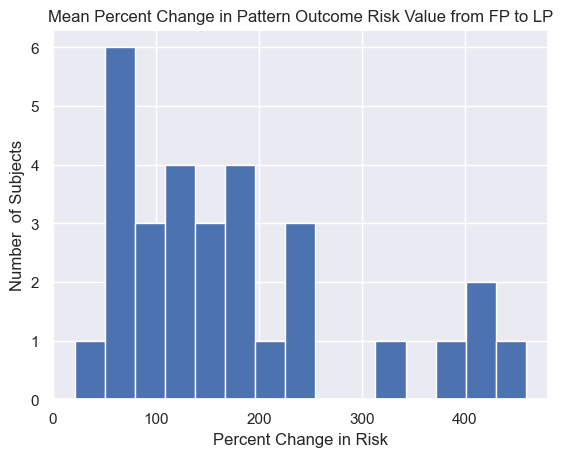

In [272]:
plt.hist(outcome_change_df['perc_change_risk'] * 100, bins=15)
plt.xlabel('Percent Change in Risk')
plt.ylabel('Number  of Subjects')
plt.title('Mean Percent Change in Pattern Outcome Risk Value from FP to LP')

In [85]:
outcome_change_df.to_csv('subj_outcome_changes.csv')

In [211]:
len(outcome_change_df[outcome_change_df['perc_change_risk'] >= .5]) / len(outcome_change_df)

0.9666666666666667

In [105]:
scipy.stats.linregress(outcome_change_df['perc_greater_highs'], outcome_change_df['weighted_change_risk'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinregressResult(slope=8.266807464544483, intercept=-1.313792707174541, rvalue=0.3179227493656818, pvalue=0.08688106993105144, stderr=4.659067059488577, intercept_stderr=0.7723755565131829)

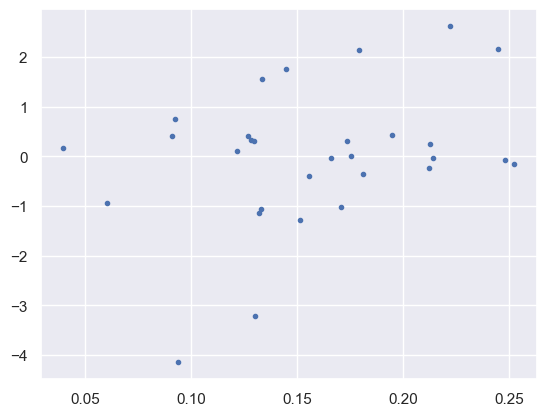

In [106]:
plt.plot(outcome_change_df['perc_greater_highs'], outcome_change_df['weighted_change_risk'], '.')

### Checking a1c correlation

In [107]:
demo_df = pd.read_csv('uva_data/subjDemo.csv')

In [108]:
demo_df = demo_df.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])

In [109]:
demo_df.columns = ['ID', 'Age', 'Weight', 'Height', 'HbA1c']

In [110]:
outcome_change_df['ID'] = outcome_change_df['ID'].astype(int)

In [111]:
demo_outcome_change_df = pd.merge(demo_df, outcome_change_df, on = 'ID')

In [112]:
means = []
for df in stats_dfs:
    means.append(df['mean'].mean())

In [113]:
demo_outcome_change_df['mean_cgm'] = means

In [114]:
scipy.stats.linregress(demo_outcome_change_df['mean_cgm'], outcome_change_df['weighted_change_risk'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinregressResult(slope=0.007478331779661333, intercept=-1.213726259024978, rvalue=0.14788055213753604, pvalue=0.43547309578332594, stderr=0.009451772013497608, intercept_stderr=1.536562400023454)

Text(0, 0.5, 'Percent of patterns with greater high specificity in LP')

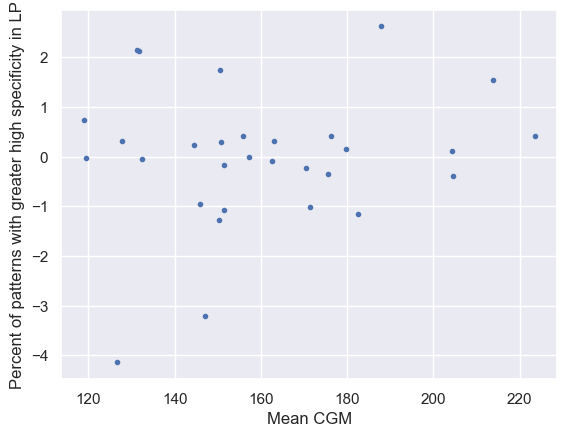

In [115]:
plt.plot(demo_outcome_change_df['mean_cgm'], outcome_change_df['weighted_change_risk'], '.')
plt.xlabel('Mean CGM')
plt.ylabel('Percent of patterns with greater high specificity in LP')

# Birth control analysis

In [98]:
# subj IDS taking hormonal birth control
hbc_ids = [78104, 78115, 78118, 78120, 78124, 78133, 78134, 78136, 78137]

### Outcome changes

In [99]:
hbc_oc_df = outcome_change_df[outcome_change_df['ID'].isin(hbc_ids)]
no_bc_oc_df = outcome_change_df[(outcome_change_df['ID'].isin(hbc_ids)) == False]

In [100]:
outcome_change_df.dtypes

ID                        int64
weighted_change_high    float64
weighted_change_low     float64
weighted_change_risk    float64
perc_change_risk        float64
std_dev_risk            float64
std_perc_risk           float64
avg_follicular_risk     float64
avg_luteal_risk         float64
perc_greater_highs      float64
perc_fewer_highs        float64
perc_greater_lows       float64
perc_fewer_lows         float64
dtype: object

In [101]:
hbc_oc_df.mean()

ID                      78124.555556
weighted_change_high        0.014105
weighted_change_low        -0.002922
weighted_change_risk       -0.264605
perc_change_risk            0.981900
std_dev_risk                7.076796
std_perc_risk               4.824598
avg_follicular_risk         8.179307
avg_luteal_risk             8.255057
perc_greater_highs          0.124347
perc_fewer_highs            0.114346
perc_greater_lows           0.033034
perc_fewer_lows             0.034966
dtype: float64

In [102]:
no_bc_oc_df.mean()

ID                      78117.904762
weighted_change_high        0.008413
weighted_change_low        -0.007101
weighted_change_risk       -0.098619
perc_change_risk            0.820058
std_dev_risk                5.040994
std_perc_risk               4.026805
avg_follicular_risk         5.931237
avg_luteal_risk             5.955140
perc_greater_highs          0.147330
perc_fewer_highs            0.139042
perc_greater_lows           0.056358
perc_fewer_lows             0.063723
dtype: float64

In [103]:
hbc_ids_int = [78104, 78115, 78118, 78120, 78124, 78133, 78134, 78136, 78137]

In [104]:
demo_outcome_change_df[demo_outcome_change_df['ID'].isin(hbc_ids_int)].mean()

ID                      78124.555556
Age                        23.777778
Weight                     79.312222
Height                    163.742222
HbA1c                       7.233333
weighted_change_high        0.014105
weighted_change_low        -0.002922
weighted_change_risk       -0.264605
perc_change_risk            0.981900
std_dev_risk                7.076796
std_perc_risk               4.824598
avg_follicular_risk         8.179307
avg_luteal_risk             8.255057
perc_greater_highs          0.124347
perc_fewer_highs            0.114346
perc_greater_lows           0.033034
perc_fewer_lows             0.034966
mean_cgm                  159.038028
dtype: float64

In [105]:
demo_outcome_change_df[demo_outcome_change_df['ID'].isin(hbc_ids_int)==False].mean()

ID                      78117.904762
Age                        28.571429
Weight                     71.650000
Height                    163.270000
HbA1c                       6.747619
weighted_change_high        0.008413
weighted_change_low        -0.007101
weighted_change_risk       -0.098619
perc_change_risk            0.820058
std_dev_risk                5.040994
std_perc_risk               4.026805
avg_follicular_risk         5.931237
avg_luteal_risk             5.955140
perc_greater_highs          0.147330
perc_fewer_highs            0.139042
perc_greater_lows           0.056358
perc_fewer_lows             0.063723
mean_cgm                  160.799431
dtype: float64

# Phase division recovery analysis
IN PROGRESS - too slow to run

In [106]:
def phase_div_recovery(phasepattdf, statsdf, bg_type):
    '''returns statistics about time to recover after pattern including high/low bg is seen divided by time'''
    # looking at patterns > 1hr
    phasepattdf = phasepattdf[phasepattdf['length'] > 1]
    
    # should hypothetically work for low bg also, but hard on hourly time scale 
    if bg_type == 'high':
        phasepattdf = phasepattdf[phasepattdf['incl_high'] == True].copy()
        val_flag = 'TAR'
    elif bg_type == 'low':
        phasepattdf = phasepattdf[phasepattdf['incl_low'] == True].copy()
        val_flag = 'TBR'
    
    # data for df construction
    recovery_data = []
    recovery_cols = ['pattern', 'length', 'repeats', 'ind_runs', 'phase', 'min_recovery', 
                     'max_recovery', 'avg_recovery', 'edge']
    
    p_runs = ['phase1_runs', 'phase2_runs', 'phase3_runs', 'phase4_runs']
    phases = ['phase1', 'phase2', 'phase3', 'phase4']

    # for each pattern, info about the pattern is applied to all phases. generates 4 rows of data, divided by phase
    for i in range(len(phasepattdf)):
        # copying info about pattern
        pattern = phasepattdf.iloc[i]['pattern']
        coord_list = phasepattdf.iloc[i]['start_coords']
        length = phasepattdf.iloc[i]['length']
        repeats = phasepattdf.iloc[i]['repeats']
        rec_times = []
        edge = False
        
        # for each phase, 
        for j in range(len(p_runs)):

            # get coords of pattern
            coord_list = json.loads(phasepattdf.iloc[i][p_runs[j]])
            for coords in coord_list:

                # get the first 'post-pattern' block positions
                start_list = [(int(coords[0]) + length), (int(coords[1]) + length)]
                # for each outcome, incl_extr is set to true and count is set to 0
                for start in start_list:
                    incl_extr = True
                    count = 0

                    # if start pos is an edge
                    if start > len(statsdf) - 1:
                        edge = True
                        break
                    # get row for the position
                    curr_row = statsdf.iloc[start]
                    # while row includes high/low bg, count + 1 and go to next row 
                    while incl_extr == True:
                        if curr_row[val_flag] > 0:
                            count += 1
                            if (start + count > (len(statsdf) - 1)): # if edge hit 
                                edge = True
                                break
                            curr_row = statsdf.iloc[start + count]
                        elif curr_row[val_flag] == 0: # break, bg has recovered
                            count += 1
                            incl_extr = False
                    rec_times.append(count) # add time to recovery to list
            # if no recovery times/no occurences in phase, set all to nan 
            if rec_times == []:
                min_rec, max_rec, avg_rec = np.nan, np.nan, np.nan
            # else, return stats about recovery times
            else:
                min_rec = min(rec_times)
                max_rec = max(rec_times)
                avg_rec = sum(rec_times) / len(rec_times)
            recovery_list = [pattern, length, repeats, coord_list, phases[j], min_rec, max_rec, avg_rec, edge]
            recovery_data.append(recovery_list)
        
    recoverydf = pd.DataFrame(recovery_data)
    recoverydf.columns = recovery_cols
    return recoverydf

In [107]:
test_id = str(stats_dfs[0].iloc[0]['id'])
stats_df = stats_dfs[0].copy()

phase_outcome_file = 'coarse/phase_outcome_dfs/' + test_id +'_coarse.csv'
phase_div_df = pd.read_csv(phase_outcome_file, low_memory = False)

In [108]:
phase_div_recovery(phase_div_df, stats_df, 'high')

KeyboardInterrupt: 

In [109]:
phase_recs_data = []
phase_cols = ['phase1', 'phase2', 'phase3', 'phase4']

for stats_df in stats_dfs:
    subj_id = str(stats_df.iloc[0]['id'])
    phase_outcome_file = 'coarse/phase_outcome_dfs/' + test_id +'_coarse.csv'
    phase_div_df = pd.read_csv(phase_outcome_file, low_memory = False)

    rec_df = phase_div_recovery(phase_div_df, stats_df, 'high')
    file_name = 'coarse/phase_rec_dfs/' + subj_id + '.csv'
    rec_df.to_csv(file_name, index = False)

    df = rec_df.copy()
    df = df[df['ind_runs'].map(lambda d: len(d)) > 0]
    for j in range(len(df)):
        pattern = df.iloc[j]['pattern']
        phase = df.iloc[j]['phase']
        avg_rec = df.iloc[j]['avg_recovery']
        phase_recs_data.append([pattern, phase, avg_rec])

KeyboardInterrupt: 

# Food outcome changes

In [116]:
has_bolus_list = []
bolus_vals_list = []
has_carbs_list = []
carbs_vals_list = []
missing_data_list = []
data_vals_list = []

# for each pattern
for patt in outcome_split_df['patt'].unique():
    # get blocks
    # blocks_included = outcome_split_df[outcome_split_df['patt'] == patt].iloc[0]['unique_blocks']
    # blocks_included = json.loads(blocks_included.replace('"','').replace("'", '"').replace(' ', ','))
    blocks_included = json.loads(patt)

    has_bolus = 0
    bolus_vals = ''
    has_carbs = 0
    carbs_vals = ''
    missing_data = 0
    data_vals = ''

    # if bolus or carb block nonzero, make has value true and add val to vals string
    for block in blocks_included:
        if block[5] != '0':
            has_bolus = 1
            bolus_vals = bolus_vals + str(block[5])
        if block[7] != '0':
            has_carbs = 1
            carbs_vals = carbs_vals + str(block[7])
        if block[8] != '5':
            missing_data = 1
            data_vals = data_vals + str(block[8])

    # times however many rows in pattern
    for i in range(len(outcome_split_df[outcome_split_df['patt'] == patt])):
        has_bolus_list.append(has_bolus)
        bolus_vals_list.append(bolus_vals)
        has_carbs_list.append(has_carbs)
        carbs_vals_list.append(carbs_vals)
        missing_data_list.append(missing_data)
        data_vals_list.append(data_vals)

# set columns
outcome_split_df['has_bolus'] = has_bolus_list
outcome_split_df['bolus_vals'] = bolus_vals_list
outcome_split_df['has_carbs'] = has_carbs_list
outcome_split_df['carbs_vals'] = carbs_vals_list
outcome_split_df['has_missing_data'] = missing_data_list
outcome_split_df['missing_data_vals'] = data_vals_list

In [117]:
food_patt_df = outcome_split_df[outcome_split_df['has_carbs']==1]

food_patt_df['cgm_diff'] = food_patt_df['l_mean_cgm'] - food_patt_df['f_mean_cgm']

bolused_for_food = food_patt_df[food_patt_df['has_bolus'] == 1]
did_not_bolus = food_patt_df[food_patt_df['has_bolus'] == 0]

/var/folders/bn/z7m_xmps3lxf8zqn27_l6vm40000gq/T/ipykernel_36217/1589559577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_patt_df['cgm_diff'] = food_patt_df['l_mean_cgm'] - food_patt_df['f_mean_cgm']


### Bolused for meal

In [118]:
bolused_for_food['high_diff'].mean()

-0.004505380927338518

In [119]:
bolused_for_food

,patt,length,unique_blocks,num_unique_blocks,num_subj,seen_subj_ids,f_perc_low_outcomes,f_num_outcomes,f_mean_cgm,f_avg_min_val,...,l_perc_high_outcomes,high_diff,low_diff,has_bolus,bolus_vals,has_carbs,carbs_vals,has_missing_data,missing_data_vals,cgm_diff
107,"['500030205', '500030305', '500030305', '50003...",4,"[""'500030205'"", ""'500030305'"", ""'500035355'""]",3,3,['78120' '78125' '78105'],0.000000,6,230.666667,201.000000,...,0.833333,-0.166667,0.000000,1,5,1,5,0,,-29.989583
133,"['500030305', '500030305', '500030305', '50003...",4,"[""'500030305'"", ""'500035355'""]",2,10,['78120' '78125' '78122' '78101' '78110' '7811...,0.026786,112,167.755813,146.117720,...,0.354167,-0.110119,-0.005952,1,5,1,5,0,,6.192718
140,"['000000300', '000005350', '000000300', '00000...",4,"[""'000000300'"", ""'000005350'""]",2,3,['78120' '78133' '78129'],0.250000,4,206.041667,189.750000,...,0.333333,0.083333,-0.250000,1,5,1,5,1,0000,-18.104167
243,"['500030505', '500030505', '500030505', '50003...",6,"[""'500030505'"", ""'500035555'""]",2,2,['78134' '78111'],0.000000,8,151.755556,135.700000,...,1.000000,0.750000,0.000000,1,5,1,5,0,,57.452778
247,"['500030505', '500030505', '500030505', '50003...",6,"[""'500030505'"", ""'500035555'""]",2,2,['78134' '78111'],0.000000,10,156.850000,134.983333,...,0.166667,-0.233333,0.166667,1,5,1,5,0,,-30.591667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,"['500030305', '500035355', '500035355', '50003...",5,"[""'500030305'"", ""'500035355'""]",2,2,['78111' '78105'],0.000000,4,238.656250,227.125000,...,0.750000,-0.250000,0.000000,1,55,1,55,0,,-75.822917
892,"['500030205', '500030305', '500030305', '50003...",9,"[""'500030205'"", ""'500030305'"", ""'500035355'""]",3,2,['78111' '78123'],0.000000,6,121.392857,103.214286,...,0.500000,0.333333,0.125000,1,5,1,5,0,,57.791667
893,"['500030105', '500030305', '500035355', '50003...",4,"[""'500030105'"", ""'500030305'"", ""'500035355'""]",3,2,['78111' '78105'],0.000000,4,170.520833,156.000000,...,1.000000,0.500000,0.000000,1,5,1,5,0,,41.895833
895,"['500030305', '500030305', '500030305', '50003...",8,"[""'500030305'"", ""'500035355'""]",2,2,['78111' '78123'],0.000000,8,165.666667,154.250000,...,0.500000,-0.125000,0.000000,1,5,1,5,0,,3.875000


In [120]:
len(bolused_for_food)

114

In [121]:
(bolused_for_food[abs(bolused_for_food['cgm_diff']) > 30]).to_csv('all_subj_bolused.csv')

### Did not bolus for meal

In [122]:
did_not_bolus['cgm_diff'].mean()

20.034605183395907

In [123]:
len(did_not_bolus)

19

In [125]:
did_not_bolus[abs(did_not_bolus['cgm_diff']) > 30]

,patt,length,unique_blocks,num_unique_blocks,num_subj,seen_subj_ids,f_perc_low_outcomes,f_num_outcomes,f_mean_cgm,f_avg_min_val,...,l_perc_high_outcomes,high_diff,low_diff,has_bolus,bolus_vals,has_carbs,carbs_vals,has_missing_data,missing_data_vals,cgm_diff
446,"['500030305', '500030305', '500030355', '50003...",5,"[""'500030305'"", ""'500030355'""]",2,2,['78125' '78136'],0.375000,8,102.427083,91.250000,...,0.187500,0.187500,-0.250000,0,,1,5,0,,41.112960
716,"['500030305', '500030305', '500030305', '50003...",5,"[""'500030305'"", ""'500030355'""]",2,2,['78136' '78121'],0.200000,10,107.329327,95.865385,...,0.357143,0.357143,-0.128571,0,,1,5,0,,59.970557
719,"['105550355', '105550305', '105550305', '10555...",4,"[""'105550305'"", ""'105550355'""]",2,2,['78136' '78121'],0.142857,14,169.686049,147.545455,...,0.833333,0.404762,0.023810,0,,1,5,0,,38.897285
722,"['500030305', '500030355', '500030305', '50003...",4,"[""'500030305'"", ""'500030355'""]",2,3,['78136' '78116' '78121'],0.115385,26,133.498576,118.186450,...,0.437500,0.245192,-0.021635,0,,1,5,0,,34.701936
725,"['500030305', '500030355', '500030305', '10504...",4,"[""'105040305'"", ""'500030305'"", ""'500030355'""]",3,2,['78136' '78121'],0.000000,6,191.069444,165.166667,...,1.000000,0.333333,0.000000,0,,1,5,0,,31.956597
726,"['105040305', '105040355', '105040305', '10504...",5,"[""'105040305'"", ""'105040355'""]",2,2,['78136' '78121'],0.000000,8,137.154321,127.925926,...,0.500000,0.500000,0.000000,0,,1,5,0,,44.461420
732,"['105040305', '105040355', '105040305', '10504...",4,"[""'105040305'"", ""'105040355'""]",2,2,['78136' '78121'],0.000000,10,144.472222,136.500000,...,0.333333,0.333333,0.000000,0,,1,5,0,,46.708333


In [126]:
(did_not_bolus[abs(did_not_bolus['cgm_diff']) > 30]).to_csv('all_subj_no_bolus.csv')

## Finding pairs with/without bolus

In [276]:
def num_mismatches(pattern1, pattern2):
    ''' returns number of mismatched blocks in two patterns of equal length'''
    if len(pattern1) != len(pattern2):
        return np.nan
    
    mismatch_count = 0
    for i in range(len(pattern1)):
        if pattern1[i] != pattern2[i]:
            mismatch_count +=1
    return mismatch_count

In [275]:
def carb_bolus_blocks(pattern1, pattern2):
    '''returns index of block that has difference in bolus base'''
    matches = []
    if len(pattern1) != len(pattern2):
        return matches
    if num_mismatches(pattern1, pattern2) != 1:
        return matches

    diff_block = ''
    for i in range(len(pattern1)):
        block1 = str(pattern1[i])
        block2 = str(pattern2[i])
        # check if both blocks contain carbs (carbs > 0)
        if block1[7] != '0' and block1[:5] + block1[6:] == block2[:5] + block2[6:]:
            # ensure that only the bolus component differs
            if block1[5] != block2[5]:  
                diff_block = i

    return diff_block

In [277]:
matches_rows = []
# use combinations with index to get indices along with patterns
for (index1, pattern1), (index2, pattern2) in itertools.combinations(outcome_split_df['patt'].items(), 2):
    pattern1 = ast.literal_eval(pattern1)
    pattern2 = ast.literal_eval(pattern2)
    differing_blocks = carb_bolus_blocks(pattern1, pattern2)

    if index1 > len(outcome_split_df) or index2 > len(outcome_split_df):
        continue

    if differing_blocks:
        # append the details including the indices of the patterns 
        # indices, pattern 1, pattern 2, pattern 1 data, pattern 2 data
        indices = [index1, index2]
        patt1_data = outcome_split_df.iloc[index1][4:]
        patt2_data = outcome_split_df.iloc[index2][4:]
        
        match_data = [indices, pattern1, pattern2, differing_blocks]
        match_data.extend(patt1_data)
        match_data.extend(patt2_data)

        matches_rows.append(match_data)

In [130]:
outcome_split_df.columns

Index(['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'num_subj',
       'seen_subj_ids', 'f_perc_low_outcomes', 'f_num_outcomes', 'f_mean_cgm',
       'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time',
       'f_end_cgm', 'l_perc_low_outcomes', 'l_num_outcomes', 'l_mean_cgm',
       'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time',
       'l_end_cgm', 'f_perc_high_outcomes', 'l_perc_high_outcomes',
       'high_diff', 'low_diff', 'has_bolus', 'bolus_vals', 'has_carbs',
       'carbs_vals', 'has_missing_data', 'missing_data_vals'],
      dtype='object')

In [131]:
match_cols = ['patt_indices', 'pattern1', 'pattern2', 'block_different',
              'num_subj1', 'seen_subj_ids1', 
              'f_perc_low_outcomes1', 'f_num_outcomes1', 'f_mean_cgm1',
              'f_avg_min_val1', 'f_avg_max_val1', 'f_avg_min_time1', 'f_avg_max_time1', 'f_end_cgm1',
              'f_perc_low_outcomes1', 'l_num_outcomes1', 'l_mean_cgm1',
              'l_avg_min_val1', 'l_avg_max_val1', 'l_avg_min_time1', 'l_avg_max_time1', 'l_end_cgm1',
              'l_perc_low_outcomes1', 'l_perc_high_outcomes1', 'high_diff1', 'low_diff1',
              'has_bolus1', 'bolus_vals1', 'has_carbs1', 'carbs_vals1',
              'has_missing_data1', 'missing_data_vals1',
              'num_subj2', 'seen_subj_ids2',
              'f_perc_low_outcomes2', 'f_num_outcome2', 'f_mean_cgm2',
              'f_avg_min_val2', 'f_avg_max_val2', 'f_avg_min_time2', 'f_avg_max_time2', 'f_end_cgm2',
              'l_perc_low_outcomes2', 'l_num_outcomes2', 'l_mean_cgm2',
              'l_avg_min_val2', 'l_avg_max_val2', 'l_avg_min_time2', 'l_avg_max_time2', 'l_end_cgm2',
              'f_perc_high_outcomes2', 'l_perc_high_outcomes2', 'high_diff2', 'low_diff2',
              'has_bolus2', 'bolus_vals2', 'has_carbs2', 'carbs_vals2',
              'has_missing_data2', 'missing_data_vals2']

In [132]:
match_df = pd.DataFrame(data = matches_rows, columns = match_cols)

In [133]:
match_df

,patt_indices,pattern1,pattern2,block_different,num_subj1,seen_subj_ids1,f_perc_low_outcomes1,f_num_outcomes1,f_mean_cgm1,f_avg_min_val1,...,f_perc_high_outcomes2,l_perc_high_outcomes2,high_diff2,low_diff2,has_bolus2,bolus_vals2,has_carbs2,carbs_vals2,has_missing_data2,missing_data_vals2
0,"[133, 338]","[500030305, 500030305, 500030305, 500035355]","[500030305, 500030305, 500030305, 500030355]",3,5,['78103' '78122' '78118' '78130' '78126'],0.0,10,141.220833,130.700000,...,0.666667,0.500000,-0.166667,-0.166667,1,55,1,55,0,
1,"[276, 722]","[500030305, 500035355, 500030305, 500030305]","[500030305, 500030355, 500030305, 500030305]",1,2,['78125' '78116'],0.0,8,191.256250,174.875000,...,0.700000,0.750000,0.050000,0.250000,0,,0,,0,
2,"[297, 718]","[500030305, 500030305, 500035355, 500030305]","[500030305, 500030305, 500030355, 500030305]",2,7,['78125' '78112' '78104' '78133' '78136' '7812...,0.1,20,155.920455,131.920455,...,0.000000,0.500000,0.500000,0.000000,0,,0,,0,
3,"[331, 446]","[500030305, 500030305, 500035355, 500030305, 5...","[500030305, 500030305, 500030355, 500030305, 5...",2,4,['78125' '78122' '78111' '78123'],0.0,8,131.941288,118.977273,...,0.125000,0.500000,0.375000,0.500000,1,5,1,5,0,
4,"[336, 721]","[500030305, 500035355, 500030305, 500030305, 5...","[500030305, 500030355, 500030305, 500030305, 5...",1,3,['78125' '78111' '78123'],0.0,10,189.569444,159.437500,...,0.750000,1.000000,0.250000,-0.125000,0,,0,,0,
5,"[339, 716]","[500030305, 500030305, 500030305, 500035355, 5...","[500030305, 500030305, 500030305, 500030355, 5...",3,6,['78125' '78112' '78122' '78110' '78111' '78123'],0.0,26,168.763399,152.552941,...,0.750000,0.500000,-0.250000,0.166667,0,,0,,0,
6,"[341, 366]","[500030305, 500030305, 500030305, 500030305, 5...","[500030305, 500030305, 500030305, 500030305, 5...",4,3,['78125' '78116' '78137'],0.0,14,171.131944,155.333333,...,0.250000,0.875000,0.625000,0.000000,1,55,1,55,0,
7,"[356, 455]","[500030305, 500030305, 500030305, 500030305, 5...","[500030305, 500030305, 500030305, 500030305, 5...",5,4,['78125' '78112' '78133' '78110'],0.0,10,153.451923,127.653846,...,0.500000,0.666667,0.166667,0.166667,0,,0,,0,
8,"[370, 720]","[500030305, 500035355, 500030305, 500030305, 5...","[500030305, 500030355, 500030305, 500030305, 5...",1,8,['78125' '78112' '78104' '78133' '78136' '7811...,0.0,26,131.722608,115.171296,...,0.500000,0.750000,0.250000,0.250000,0,,0,,0,
9,"[381, 728]","[500030305, 500030305, 500030305, 500030305, 5...","[500030305, 500030305, 500030305, 500030305, 5...",4,3,['78112' '78136' '78121'],0.0,14,125.780220,112.368132,...,0.500000,0.000000,-0.500000,0.000000,0,,0,,0,


In [134]:
match_df.to_csv('matched_patterns.csv')

In [135]:
# getting differences in outcomes for matched patterns - UPDATE WITH PEAKS/END CGM
match_diffs_data = []
for i in range(len(match_df)):
    # info about patterns
    indices, pattern1, pattern2, block_different = match_df.iloc[i][:4]

    # getting data from each pattern, difference between
    data_arr_1 = (match_df.iloc[i][4:14]).to_numpy()
    data_arr_2 = (match_df.iloc[i][20:30]).to_numpy()
    data_diffs = data_arr_2 - data_arr_1

    # info: has_bolus, bolus_vals, has_carbs, carbs_vals, has_missing_data, missing_data_vals
    patt_info_1 = (match_df.iloc[i][14:20]).to_numpy()
    patt_info_2 = (match_df.iloc[i][30:]).to_numpy()

    # extending row data to include diffs and pattern info
    match_diff_row = [indices, pattern1, pattern2, block_different]

    match_diff_row.extend(data_diffs)
    match_diff_row.extend(patt_info_1)
    match_diff_row.extend(patt_info_2)

    match_diffs_data.append(match_diff_row)

match_diffs_cols = ['patt_indices', 'pattern1', 'pattern2', 'block_different',
       'f_perc_low_outcomes_diff', 'f_num_outcomes_diff', 'f_mean_cgm_diff',
       'l_perc_low_outcomes_diff', 'l_num_outcomes_diff', 'l_mean_cgm_diff',
       'f_perc_high_outcomes_diff', 'l_perc_high_outcomes_diff', 'high_diff_diff',
       'low_diff_diff', 'has_bolus1', 'bolus_vals1', 'has_carbs1', 'carbs_vals1',
       'has_missing_data1', 'missing_data_vals1' ,'has_bolus2',
       'bolus_vals2', 'has_carbs2', 'carbs_vals2', 'has_missing_data2',
       'missing_data_vals2']

match_diffs_df = pd.DataFrame(match_diffs_data, columns = match_diffs_cols)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('float64'), dtype('<U41')) -> None

In [236]:
match_diffs_df.to_csv('matched_pattern_diffs.csv')

# Missing CGM data

In [136]:
missing_cgm_df = outcome_split_df[outcome_split_df['has_missing_data'] == 1]

In [137]:
missing_cgm_df.columns

Index(['patt', 'length', 'unique_blocks', 'num_unique_blocks', 'num_subj',
       'seen_subj_ids', 'f_perc_low_outcomes', 'f_num_outcomes', 'f_mean_cgm',
       'f_avg_min_val', 'f_avg_max_val', 'f_avg_min_time', 'f_avg_max_time',
       'f_end_cgm', 'l_perc_low_outcomes', 'l_num_outcomes', 'l_mean_cgm',
       'l_avg_min_val', 'l_avg_max_val', 'l_avg_min_time', 'l_avg_max_time',
       'l_end_cgm', 'f_perc_high_outcomes', 'l_perc_high_outcomes',
       'high_diff', 'low_diff', 'has_bolus', 'bolus_vals', 'has_carbs',
       'carbs_vals', 'has_missing_data', 'missing_data_vals'],
      dtype='object')

In [138]:
missing_cgm_df.sort_values('missing_data_vals')

,patt,length,unique_blocks,num_unique_blocks,num_subj,seen_subj_ids,f_perc_low_outcomes,f_num_outcomes,f_mean_cgm,f_avg_min_val,...,f_perc_high_outcomes,l_perc_high_outcomes,high_diff,low_diff,has_bolus,bolus_vals,has_carbs,carbs_vals,has_missing_data,missing_data_vals
25,"['500030000', '500030005', '500030005', '50003...",4,"[""'500030000'"", ""'500030005'""]",2,2,['78117' '78108'],0.00,8,131.955729,108.750000,...,0.00,0.125000,0.125000,0.00,0,,0,,1,0
134,"['000000300', '000000300', '000000300', '00000...",4,"[""'000000200'"", ""'000000300'""]",2,2,['78120' '78137'],0.00,6,167.476190,149.285714,...,0.50,0.500000,0.000000,0.00,0,,0,,1,0000
140,"['000000300', '000005350', '000000300', '00000...",4,"[""'000000300'"", ""'000005350'""]",2,3,['78120' '78133' '78129'],0.25,4,206.041667,189.750000,...,0.25,0.333333,0.083333,-0.25,1,5,1,5,1,0000
733,"['000000300', '000000300', '000000100', '00000...",4,"[""'000000100'"", ""'000000300'""]",2,2,['78101' '78129'],0.00,2,154.125000,127.000000,...,0.50,0.625000,0.125000,0.00,0,,0,,1,0000
737,"['000000500', '000000500', '000000500', '00000...",4,"[""'000000300'"", ""'000000500'""]",2,2,['78101' '78129'],0.00,2,120.500000,107.000000,...,0.50,0.000000,-0.500000,0.00,0,,0,,1,0000
549,"['000000300', '000000300', '000000300', '00000...",5,"[""'000000300'"", ""'105040300'""]",2,2,['78112' '78136'],0.50,2,94.125000,69.000000,...,0.00,0.500000,0.500000,-0.25,0,,0,,1,00000
137,"['000000200', '000000300', '000000300', '00000...",13,"[""'000000200'"", ""'000000300'""]",2,2,['78120' '78137'],0.00,2,NaN,NaN,...,0.00,0.000000,0.000000,0.00,0,,0,,1,0000000000000


In [256]:
(missing_cgm_df.sort_values('missing_data_vals')).to_csv('missing_cgm_data.csv')

# Menstrual cycle variability

In [324]:
data = 'menstruation_dates.csv'
dates_df = pd.read_csv(data)

In [325]:
def calculate_cycle_lengths(dates):
    # Convert string dates to datetime objects
    dates = [datetime.strptime(date.strip("'"), '%Y-%m-%d') for date in dates]
    
    # Calculate cycle lengths (differences between consecutive start dates)
    cycle_lengths = [(dates[i+1] - dates[i]).days for i in range(len(dates) - 1)]
    
    return cycle_lengths

In [326]:
dates_df['cycle_lengths'] = dates_df['Menses dates (str)'].apply(lambda x: calculate_cycle_lengths(eval(x)))

# Filter out rows where there are less than 2 complete cycles (incomplete cycles)
dates_df['complete_cycles'] = dates_df['cycle_lengths'].apply(lambda x: x if len(x) > 0 else np.nan)

# Calculate the average, median, and standard deviation of cycle lengths
dates_df['avg_length'] = dates_df['complete_cycles'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
dates_df['median_length'] = dates_df['complete_cycles'].apply(lambda x: np.median(x) if isinstance(x, list) else np.nan)
dates_df['std_dev_length'] = dates_df['complete_cycles'].apply(lambda x: np.std(x) if isinstance(x, list) else np.nan)

In [327]:
outcome_change_df.dtypes

ID                        int64
weighted_change_high    float64
weighted_change_low     float64
weighted_change_risk    float64
perc_change_risk        float64
std_dev_risk            float64
std_perc_risk           float64
avg_follicular_risk     float64
avg_luteal_risk         float64
perc_greater_highs      float64
perc_fewer_highs        float64
perc_greater_lows       float64
perc_fewer_lows         float64
dtype: object

In [328]:
dates_df['ID'] = dates_df['ID'].apply(lambda x: int(x[0]) if isinstance(x, list) and len(x) == 1 else x)

In [329]:
id_list = []
for i in range(len(dates_df)):
    id_list.append(int(dates_df.iloc[i]['ID'][1:-1]))

In [330]:
dates_df['ID'] = id_list

In [331]:
date_outcome_stats_df = pd.merge(demo_outcome_change_df, dates_df, on='ID', how='inner')

In [302]:
date_outcome_stats_df.columns

Index(['ID', 'Age', 'Weight', 'Height', 'HbA1c', 'weighted_change_high',
       'weighted_change_low', 'weighted_change_risk', 'perc_change_risk',
       'std_dev_risk', 'std_perc_risk', 'avg_follicular_risk',
       'avg_luteal_risk', 'perc_greater_highs', 'perc_fewer_highs',
       'perc_greater_lows', 'perc_fewer_lows', 'mean_cgm', 'Unnamed: 0',
       'Menses dates', 'Ovulation dates', 'Group', 'Menses dates (str)',
       'Ovulation dates (str)', 'inferred ovulation dates',
       'filled ovulation dates', 'cycle_lengths', 'complete_cycles',
       'avg_length', 'median_length', 'std_dev_length'],
      dtype='object')

In [402]:
date_outcome_stats_df = date_outcome_stats_df.drop(20)

In [403]:
scipy.stats.linregress(date_outcome_stats_df['Age'], date_outcome_stats_df['std_dev_length'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinregressResult(slope=-0.05391566082416489, intercept=3.8216673409534794, rvalue=-0.1167827012119335, pvalue=0.5463085203874749, stderr=0.08824145418771501, intercept_stderr=2.438271603207644)

In [321]:
date_outcome_stats_df.sort_values('avg_length')

,ID,Age,Weight,Height,HbA1c,weighted_change_high,weighted_change_low,weighted_change_risk,perc_change_risk,std_dev_risk,...,Group,Menses dates (str),Ovulation dates (str),inferred ovulation dates,filled ovulation dates,cycle_lengths,complete_cycles,avg_length,median_length,std_dev_length
5,78109,19,51.26,160.00,6.3,-0.023989,0.003966,-0.316936,0.603897,2.455871,...,[0],"['2021-07-18', '2021-08-13', '2021-09-02']","['2021-08-02', '2021-08-25', '2021-09-14']",[],"['2021-08-02', '2021-08-25', '2021-09-14']","[26, 20]","[26, 20]",23.000000,23.0,3.000000
16,78122,28,104.33,172.70,7.8,-0.002383,0.002106,-0.405668,0.265081,5.070457,...,[0],"['2021-06-30', '2021-07-21', '2021-08-20', '20...","['2021-08-31', '2021-09-26']","['2021-07-10', '2021-08-05']","['2021-07-10', '2021-08-05', '2021-08-31', '20...","[21, 30, 26]","[21, 30, 26]",25.666667,26.0,3.681787
3,78105,38,86.70,170.18,7.0,0.018241,-0.007653,0.252814,0.958567,3.682960,...,[0],"['2021-02-14', '2021-03-12', '2021-04-07']","['2021-02-24', '2021-03-23', '2021-04-18']",[],"['2021-02-24', '2021-03-23', '2021-04-18']","[26, 26]","[26, 26]",26.000000,26.0,0.000000
10,78115,20,70.60,162.60,5.9,0.002457,-0.009039,0.176059,0.615734,2.860490,...,[1],"['2021-05-20', '2021-06-15', '2021-07-13', '20...",[],"['2021-06-02', '2021-06-29', '2021-07-25', '20...","['2021-06-02', '2021-06-29', '2021-07-25', '20...","[26, 28, 25]","[26, 28, 25]",26.333333,26.0,1.247219
13,78118,25,83.01,163.00,7.9,0.058557,-0.027075,0.409592,0.765317,3.296412,...,[1],"['2021-06-21', '2021-07-18', '2021-08-14']",[],"['2021-07-04', '2021-07-31', '2021-08-27']","['2021-07-04', '2021-07-31', '2021-08-27']","[27, 27]","[27, 27]",27.000000,27.0,0.000000
0,78101,40,83.91,161.29,8.3,0.019644,-0.000505,-0.578677,0.895534,5.149370,...,[0],"['2021-03-12', '2021-04-10', '2021-05-05']","['2021-02-24', '2021-03-25', '2021-04-27', '20...",[],"['2021-02-24', '2021-03-25', '2021-04-27', '20...","[29, 25]","[29, 25]",27.000000,27.0,2.000000
1,78103,30,86.18,182.88,6.3,0.034672,-0.039853,0.464894,2.181849,3.530150,...,[0],"['2021-03-23', '2021-04-18', '2021-05-17']","['2021-04-06', '2021-05-04', '2021-05-30']",[],"['2021-04-06', '2021-05-04', '2021-05-30']","[26, 29]","[26, 29]",27.500000,27.5,1.500000
6,78110,33,86.10,172.70,7.3,0.146784,-0.075672,1.859580,1.520776,7.233063,...,[0],"['2021-04-13', '2021-05-13', '2021-06-08']","['2021-04-25', '2021-05-24', '2021-06-23']",[],"['2021-04-25', '2021-05-24', '2021-06-23']","[30, 26]","[30, 26]",28.000000,28.0,2.000000
25,78133,22,90.72,170.18,8.2,0.037808,0.000000,1.230851,0.268921,7.610949,...,[1],"['2021-10-12', '2021-11-11', '2021-12-07']",[],"['2021-10-27', '2021-11-24', '2021-12-21']","['2021-10-27', '2021-11-24', '2021-12-21']","[30, 26]","[30, 26]",28.000000,28.0,2.000000
21,78128,36,52.16,160.96,6.9,-0.066636,-0.011361,-1.424298,0.681206,10.874670,...,[0],"['2021-08-13', '2021-09-11', '2021-10-08']","['2021-08-01', '2021-08-30', '2021-09-26', '20...",[],"['2021-08-01', '2021-08-30', '2021-09-26', '20...","[29, 27]","[29, 27]",28.000000,28.0,1.000000


In [333]:
date_outcome_stats_df.to_csv('dates_outcomes.csv')

(array([ 1.,  3., 11.,  4.,  2.,  4.,  1.,  1.,  0.,  2.]),
 array([23., 25., 27., 29., 31., 33., 35., 37., 39., 41., 43.]),
 <BarContainer object of 10 artists>)

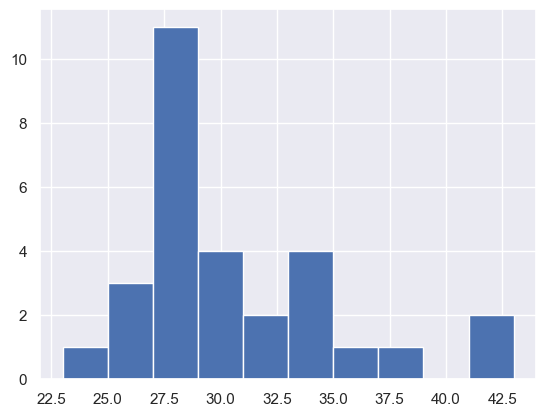

In [394]:
plt.hist(date_outcome_stats_df['avg_length'], bins=10)

(array([ 1.,  3., 12.,  3.,  3.,  3.,  1.,  1.,  0.,  2.]),
 array([23., 25., 27., 29., 31., 33., 35., 37., 39., 41., 43.]),
 <BarContainer object of 10 artists>)

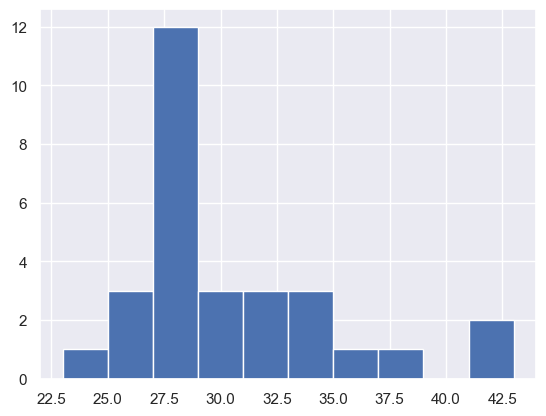

In [395]:
plt.hist(date_outcome_stats_df['median_length'], bins=10)

In [396]:
date_outcome_stats_df.columns

Index(['ID', 'Age', 'Weight', 'Height', 'HbA1c', 'weighted_change_high',
       'weighted_change_low', 'weighted_change_risk', 'perc_change_risk',
       'std_dev_risk', 'std_perc_risk', 'avg_follicular_risk',
       'avg_luteal_risk', 'perc_greater_highs', 'perc_fewer_highs',
       'perc_greater_lows', 'perc_fewer_lows', 'mean_cgm', 'Unnamed: 0',
       'Menses dates', 'Ovulation dates', 'Group', 'Menses dates (str)',
       'Ovulation dates (str)', 'inferred ovulation dates',
       'filled ovulation dates', 'cycle_lengths', 'complete_cycles',
       'avg_length', 'median_length', 'std_dev_length'],
      dtype='object')

In [ ]:
coor_df = date_outcome_stats_df.drop(axis=0)

In [412]:
scipy.stats.linregress(date_outcome_stats_df['mean_cgm'], date_outcome_stats_df['avg_length'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinregressResult(slope=0.050237282900196266, intercept=22.32529471674441, rvalue=0.29355286535583863, pvalue=0.12220802053705423, stderr=0.03148399694632068, intercept_stderr=5.148007325023987)